# Исследование рыночной стоимости объектов недвижимости

Наш заказчик, сервис Яндекс.Недвижимость, передаёт нам архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нам нужно определить рыночную стоимость объектов недвижимости. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
!pip install missingno

import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

pd.set_option('display.max_columns', None)

## Откроем файл с данными и изучим общую информацию. 

Изучим общую информацию по набору данных.

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

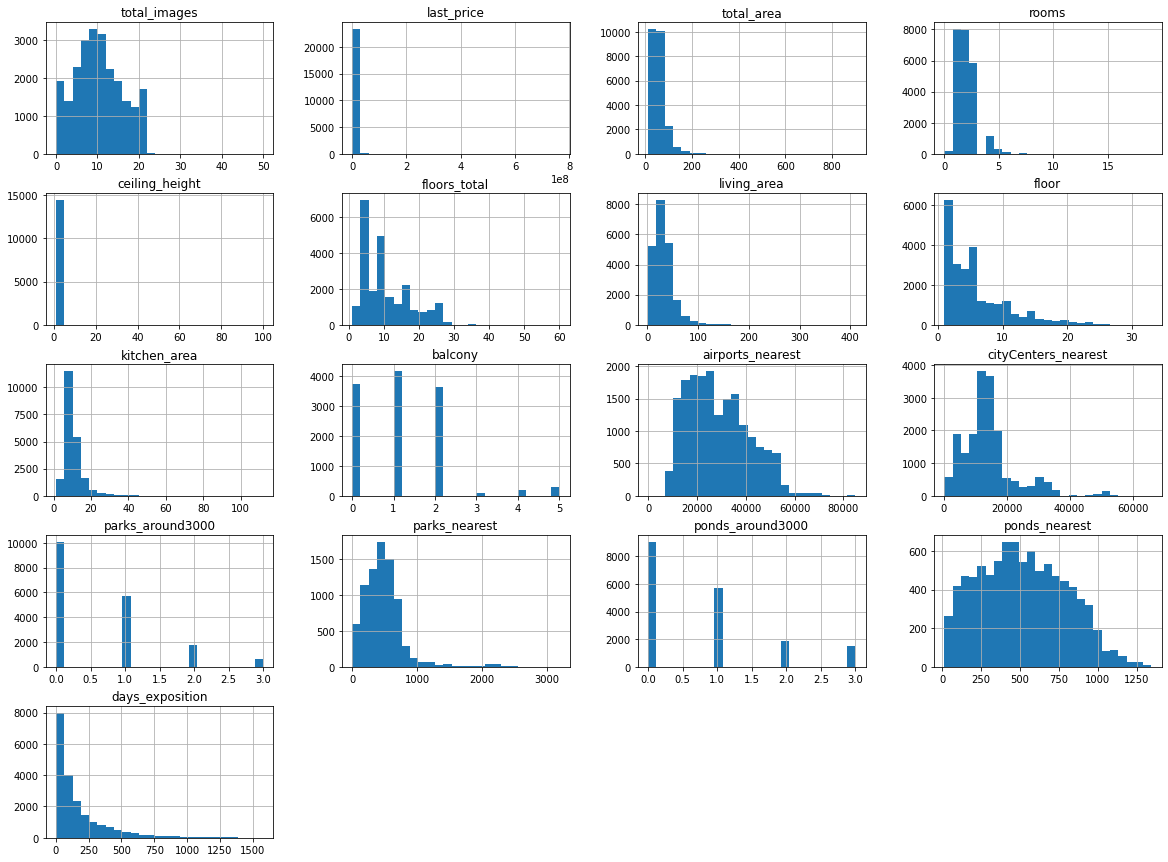

In [4]:
df.hist(figsize=(20, 15), bins=25)
plt.show()

**Вывод:** как мы заметили из первичного анализа, в дальнейшем этапе предобработки нам необходимо будет:
- разобраться с большим количеством пропусков в данных;
- там где это возможно преобразовать вещественные значения в целочисленные и изменить тип столбца "first_day_exposition" на datetime;
- определить, что считать аномалиями (отнюдь не все графики нормально распределены) и избавиться от них;
- выяснить, присутствуют ли дубликаты в данных, как явные, так и неявные;
- привести названия столбцов к единому формату - для дальнейшего удобного анализа.

## Предобработка данных

### Обработка пропущенных значений

Определим, в каких столбцах есть пропуски.

In [5]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Воспользуемся для наглядности библиотекой missingno - матрицей пропущенных значений и гистограммой.

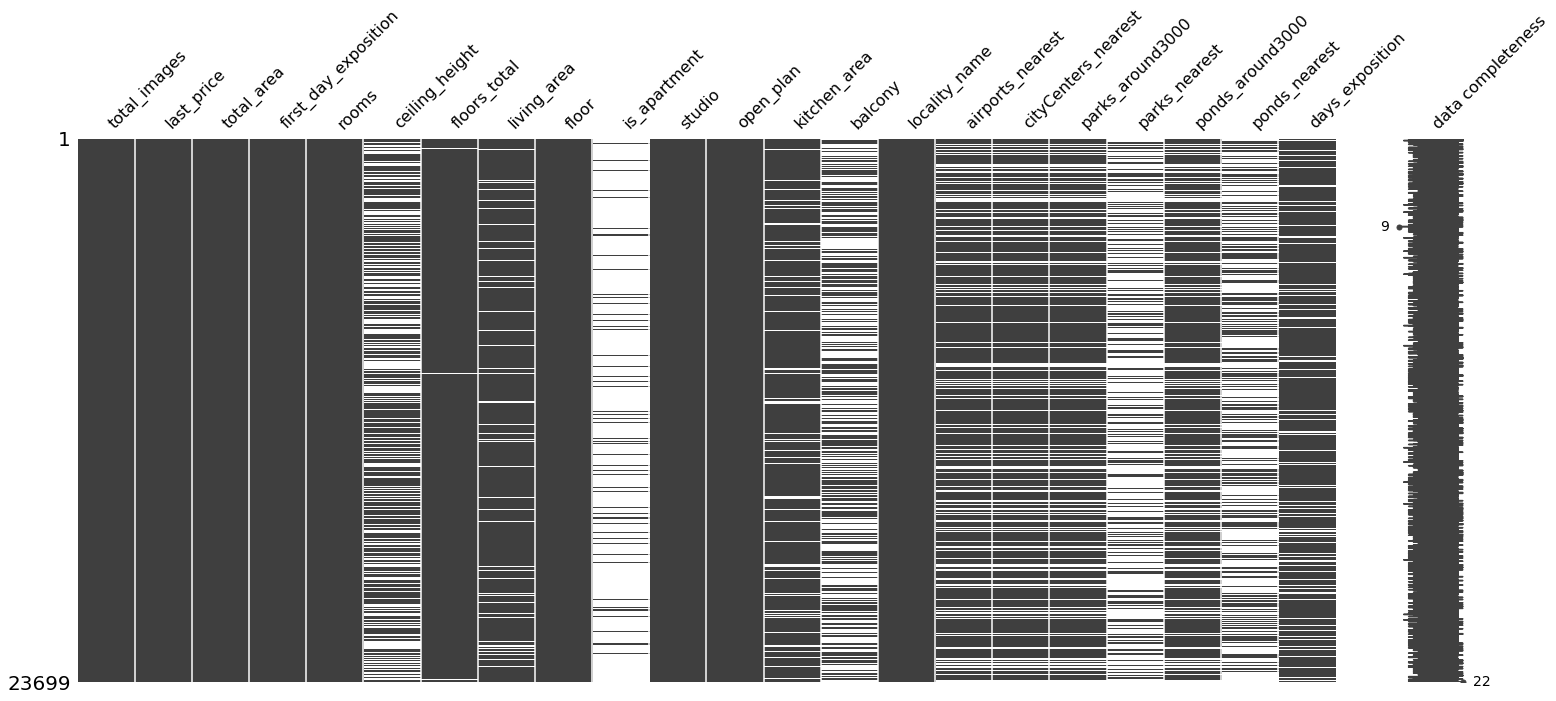

In [6]:
msno.matrix(df, labels=True)
plt.show()

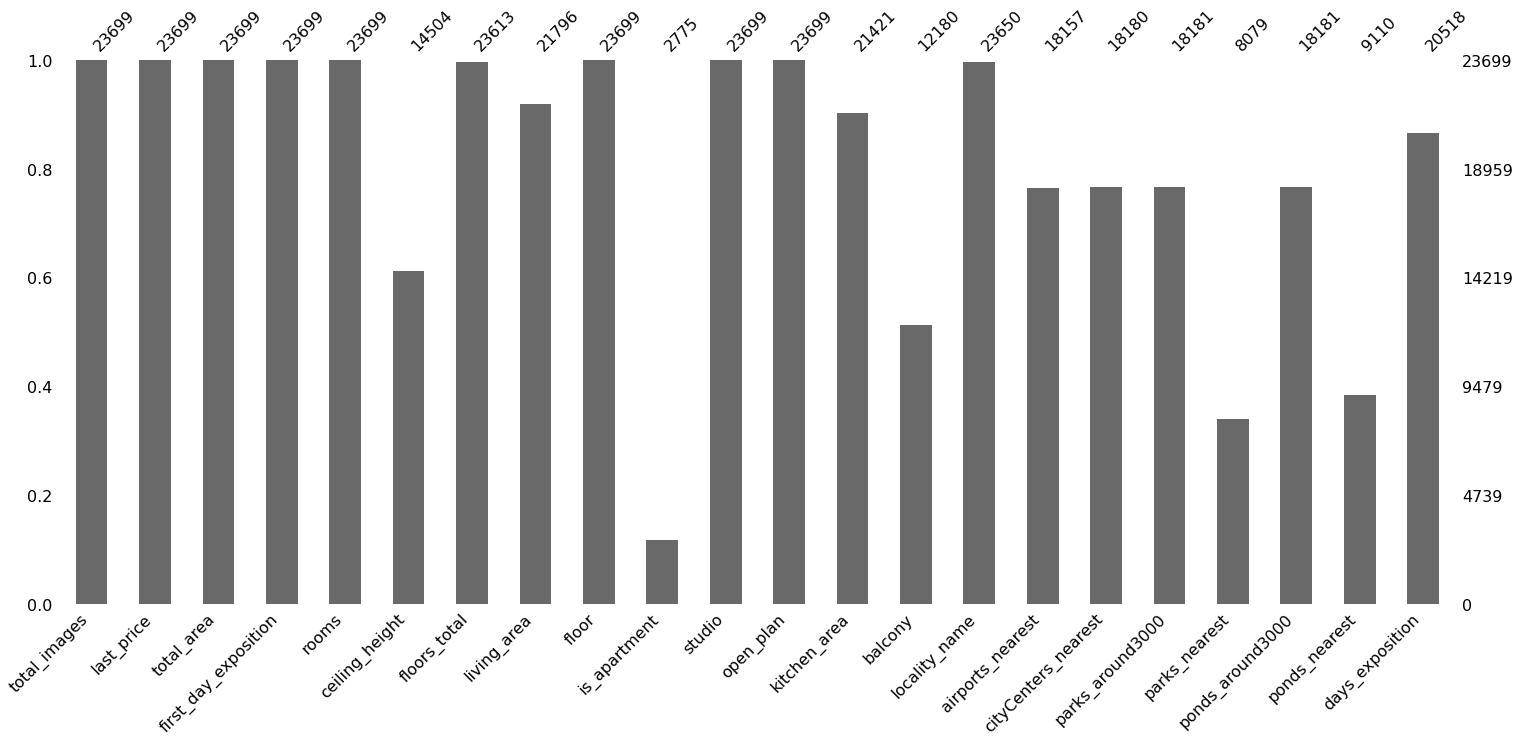

In [7]:
msno.bar(df)
plt.show()

Как мы видим, пропуски присутствуют в столбцах:
- высота потолков;
- общее количество этажей в доме;
- площадь жилого пространства;
- тип объекта - апартаменты или нет;
- площадь кухни;
- наличие балкона;
- название населённого пункта;
- наличие парка и водоёма поблизости;
- расстояние до аэропорта, центра, парка и водоёма;
- длительность продажи.

Мы не хотим исказить данные, поэтому мы можем заполнить пропуски только в 2ух столбцах:
- тип объекта - апартаменты или нет;
- наличие балкона.
Т.к. скорее всего, если не указан тип объекта (апартаменты), то подразумевается отрицательный ответ; а если не указано количество балконов, то их нет.

In [8]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df['balcony'] = df['balcony'].fillna(0)

У нас большое количество данных с пропущенными значениями дальности до ближайшего парка и водоёма. Скорее всего, это от того, что ближайшего парка/водоёма в пределах 3 км просто нет. Проверим:

In [9]:
print(len(df[(df['parks_nearest'].isna()) & (df['parks_around3000'] == 0)]))
print(len(df[(df['ponds_nearest'].isna()) & (df['ponds_around3000'] == 0)]))

10102
9071


Проверим, есть ли взаимосвязь между пропущенными значениями площадей жилого пространства и кухни:

In [10]:
len(df[(df['living_area'].isna()) & (df['kitchen_area'].isna())])

1464

Воспользуемся библиотекой missingno для построения тепловой карты корреляций пропущенных значений.

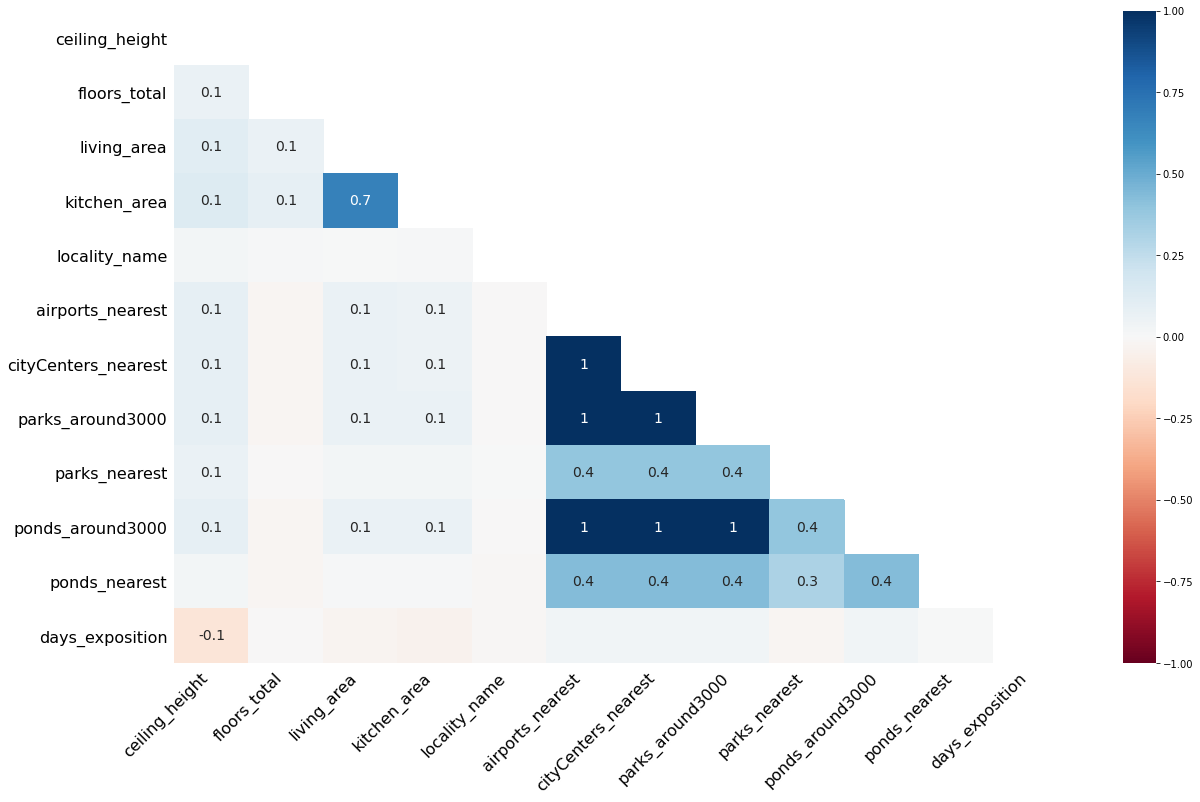

In [11]:
msno.heatmap(df)
plt.show()

Как видно из тепловой карты, обнаружены корреляции пропусков между:
- площадью кухни и жилой площадью (выше среднего);
- расстоянием до центра и расстоянием до аэропорта, количеством парков и водоёмов в пределах 3 км (очень сильная);
- расстоянием до парка и водоёма и расстоянием до аэропорта, количеством парков и водоёмов в пределах 3 км (ниже среднего).


**Вывод:** видимо, часть объектов недвижимости была изначально внесена в базу данных без значений:
- высота потолков;
- общее количество этажей в доме;
- площадь жилого пространства;
- тип объекта - апартаменты или нет;
- площадь кухни;
- наличие балкона;
- название населённого пункта;
- расстояние до аэропорта, центра, парка и водоёма;
- длительность продажи (т.к. продажа ещё не была совершена).

Это объясняется человеческим фактором.

Но также мы видим и технические ошибки при загрузке данных из других источников - целых **5518 записей без значений**:
- наличие парка в 3 км;
- наличие водоёма в 3 км;
- расстояние до аэропорта;
- расстояние до центра;
- расстояние до водоёма;
- расстояние до парка.

Наличие такого количества записей с одновременным отсутствием таких параметров может быть объяснено только техническими ошибками.

### Изменение типов данных

Из сводки по нашему набору данных, мы видим, что дата публикации (`first_day_exposition`) имеет тип данных `object`, а также столбцы, которые по логике должны иметь тип данных `int32`, имеют `float64`: `balcony`, `floors_total`, `parks_around3000`, `ponds_around3000` и `days_exposition`

Изменим тип `first_day_exposition` на `datetime64` и `balcony` на `int32`. Столбцы `floors_total`, `parks_around3000`, `ponds_around3000` и `days_exposition` привести к типу `int32` мы не сможем, т.к. в них присутствуют значения `NaN`.

In [12]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df = df.astype({'balcony':'int32'})

С помощью столбца `first_day_exposition`, приведённого к типу `datetime64` мы позднее сможем легко создать новые столбцы "день", "месяц" и "год публикации объявления".

### Поиск дубликатов

Проверим наш набор данных на наличие неявных дубликатов в столбце `locality_name`.

In [13]:
for name in df['locality_name'].sort_values().unique():
    print(name)

Бокситогорск
Волосово
Волхов
Всеволожск
Выборг
Высоцк
Гатчина
Зеленогорск
Ивангород
Каменногорск
Кингисепп
Кириши
Кировск
Колпино
Коммунар
Красное Село
Кронштадт
Кудрово
Лодейное Поле
Ломоносов
Луга
Любань
Мурино
Никольское
Новая Ладога
Отрадное
Павловск
Петергоф
Пикалёво
Подпорожье
Приморск
Приозерск
Пушкин
Санкт-Петербург
Светогорск
Сертолово
Сестрорецк
Сланцы
Сосновый Бор
Сясьстрой
Тихвин
Тосно
Шлиссельбург
городской поселок Большая Ижора
городской поселок Янино-1
городской посёлок Будогощь
городской посёлок Виллози
городской посёлок Лесогорский
городской посёлок Мга
городской посёлок Назия
городской посёлок Новоселье
городской посёлок Павлово
городской посёлок Рощино
городской посёлок Свирьстрой
городской посёлок Советский
городской посёлок Фёдоровское
городской посёлок Янино-1
деревня Агалатово
деревня Аро
деревня Батово
деревня Бегуницы
деревня Белогорка
деревня Большая Вруда
деревня Большая Пустомержа
деревня Большие Колпаны
деревня Большое Рейзино
деревня Большой Сабск
деревня 

Как мы видим, у нас возникло множество дубликатов из-за несогласованного написания слова "посёлок" - то через е, то через ё. Исправим это допущение с помощью метода `str.replace()`.

In [14]:
df['locality_name'] = df['locality_name'].str.replace('поселок', 'посёлок')

Теперь проверим данные на наличие явных дубликатов.

In [15]:
df.duplicated().sum()

0

Отлично, значит, с дубликатами закончили.

### Поиск аномалий

Изучим данные на предмет аномалий. Построим гистограммы, чтобы определить возможные выбросы.

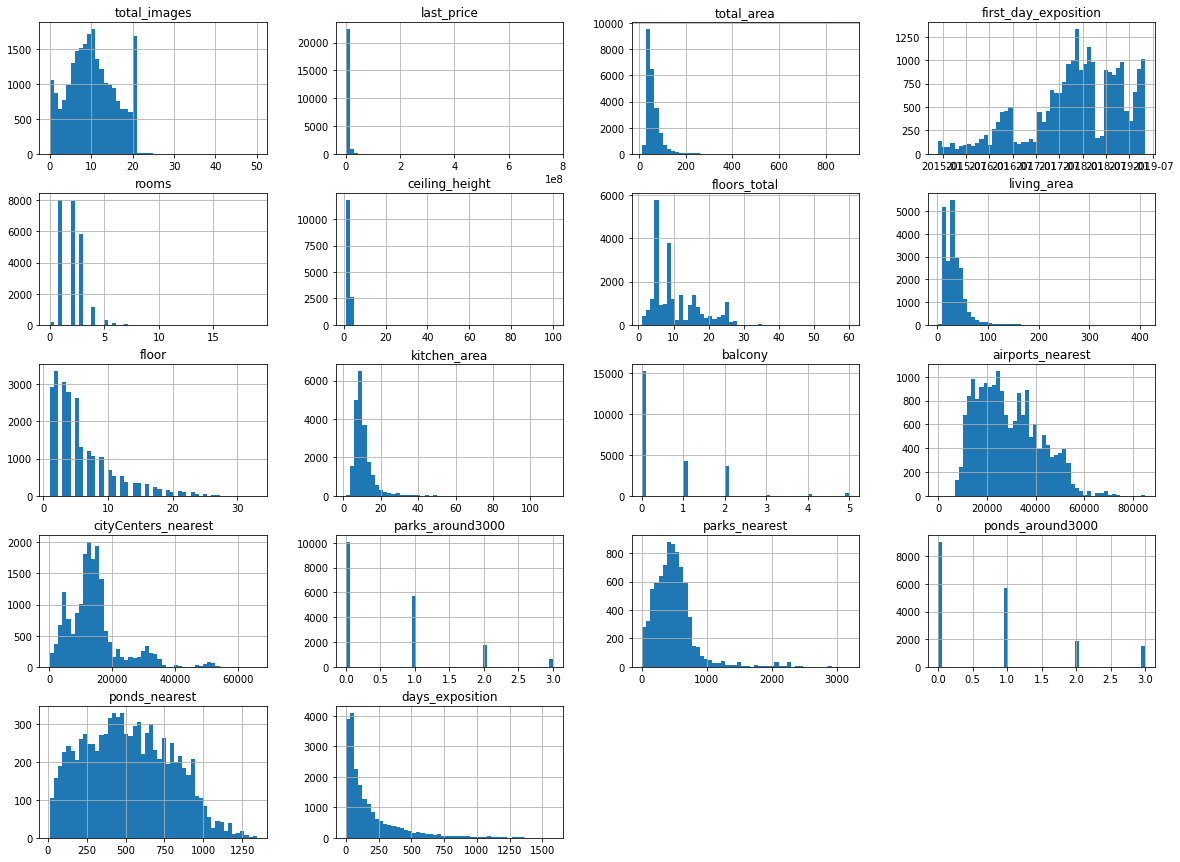

In [16]:
df.hist(figsize=(20, 15), bins=50)
plt.show()

Большие значения `last_price` (больше 100 миллионов) нас не должны удивлять - в набор данных попали, видимо, объекты и элитной недвижимости. `total_area`, `living_area`, `kitchen_area` тоже в пределах возможного. `floor`, `floors_total`, `balcony` - с этажностью и количеством балконов всё в порядке. А вот `ceiling_height` и `rooms` заставляют насторожиться. Слабо представляется недвижимость с потолками в 20 метров, либо с количеством комнат равных 0.

In [17]:
df[df['rooms'] == 0].sort_values(by='total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8886,10,2450000.0,15.5,2018-08-22,0,NaN,5.0,10.0,2,False,True,False,NaN,0,Санкт-Петербург,24326.0,4589.0,0.0,NaN,1.0,446.0,27.0
9412,5,2100000.0,16.0,2017-12-10,0,NaN,6.0,13.0,1,False,False,True,NaN,0,Санкт-Петербург,20735.0,2111.0,2.0,228.0,3.0,72.0,3.0
716,5,1500000.0,17.0,2017-06-07,0,2.70,9.0,12.0,1,False,True,False,NaN,0,посёлок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0
12996,8,1900000.0,18.0,2019-01-25,0,2.60,5.0,16.0,3,False,True,False,NaN,0,Санкт-Петербург,19573.0,15772.0,2.0,149.0,2.0,496.0,10.0
8755,1,1350000.0,18.8,2017-11-22,0,2.75,19.0,15.8,1,False,True,False,NaN,0,Санкт-Петербург,37636.0,14479.0,0.0,NaN,1.0,1127.0,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13613,16,8100000.0,58.4,2019-04-26,0,3.30,7.0,33.0,6,False,True,False,NaN,0,Санкт-Петербург,14509.0,8288.0,0.0,NaN,0.0,NaN,NaN
21227,0,8200000.0,71.0,2017-07-21,0,5.80,5.0,68.0,5,False,True,False,NaN,0,Санкт-Петербург,20170.0,1261.0,2.0,295.0,3.0,366.0,30.0
3458,6,7400000.0,73.6,2017-05-18,0,NaN,3.0,50.0,1,False,True,False,NaN,0,Санкт-Петербург,26581.0,6085.0,0.0,NaN,1.0,348.0,60.0
20082,10,16300000.0,98.4,2017-11-08,0,3.10,5.0,60.5,2,False,True,False,NaN,0,Санкт-Петербург,26972.0,5819.0,0.0,NaN,1.0,674.0,537.0


Может быть, квартиры с 0 комнат - это студии?

In [18]:
df[(df['rooms'] == 0) & (df['is_apartment'])].sort_values(by='total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Видимо, всё же, квартиры с 0 комнат - аномалии.

In [19]:
df[df['ceiling_height'] > 5].sort_values(by='ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
464,15,66571000.0,280.3,2015-06-11,6,5.2,8.0,159.5,7,False,False,False,21.1,0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
12628,14,3900000.0,50.0,2018-03-29,1,5.3,5.0,NaN,5,False,False,False,NaN,0,Санкт-Петербург,19644.0,3918.0,1.0,505.0,1.0,92.0,8.0
1026,20,155000000.0,310.0,2018-10-12,5,5.3,3.0,190.0,3,False,False,False,63.0,2,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
7578,17,38000000.0,143.0,2017-11-02,3,5.5,5.0,83.0,5,False,False,False,29.0,1,Санкт-Петербург,26333.0,6448.0,3.0,479.0,0.0,NaN,NaN
1388,20,59800000.0,399.0,2015-01-21,5,5.6,6.0,NaN,6,False,False,False,NaN,0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
21227,0,8200000.0,71.0,2017-07-21,0,5.8,5.0,68.0,5,False,True,False,NaN,0,Санкт-Петербург,20170.0,1261.0,2.0,295.0,3.0,366.0,30.0
20264,17,119000000.0,187.6,2017-07-10,4,6.0,7.0,147.0,7,False,False,False,15.6,0,Санкт-Петербург,26902.0,5605.0,3.0,484.0,1.0,305.0,259.0
17442,0,5350000.0,54.0,2015-06-16,2,8.0,5.0,29.0,2,False,False,False,NaN,1,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0
15743,14,5600000.0,67.0,2016-11-11,3,8.0,16.0,41.0,1,False,False,False,8.0,0,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,False,False,7.3,0,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0


Судя по всему, там где потолки указаны в 20 и больше метров, была совершена ошибка - подразумевалось в 10 раз меньше. Исправим это. А вот объекты с 0 комнат просто так не исправишь - удалим их.

In [20]:
df.loc[(df['ceiling_height'] >= 20), 'ceiling_height'] = df['ceiling_height'] / 10
df = df.query('rooms > 0')

### Переименование столбцов

Приведём названия всех столбцов к единому формату.

In [21]:
df.columns = [col.lower() for col in df.columns]

---
**Вывод:** мы завершили этап предобработки данных,
- обработали пропущенные значения в столбцах "количество балконов" и "тип объекта (апартаменты)";
- обнаружили, что при загрузке данных была произведена техническая ошибка, которая привела к тому, что 5518 записей одновременно потеряли значения в 6 столбцах;
- изменили типы данных даты публикации (на datetime) и количества балконов (int);
- обнаружили и исправили неявные дубликаты в столбце "имя населённого пункта";
- обнаружили аномалии в столбцах "высота потолков" и "количество комнат"; часть записей была исправлена, а часть - отброшена;
- привели названия всех столбцов к единому типу.



## Посчитайте и добавьте в таблицу новые столбцы

Добавим новые столбцы:
- цена одного квадратного метра (`price_meter`);
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее) (`exposition_day`);
- месяц публикации объявления (`exposition_month`);
- год публикации объявления (`exposition_year`);
- расстояние до центра города в километрах (`citycenters_km`).

In [22]:
df['price_meter'] = df['last_price'] / df['total_area']
df['exposition_day'] = df['first_day_exposition'].dt.dayofweek
df['exposition_month'] = df['first_day_exposition'].dt.month
df['exposition_year'] = df['first_day_exposition'].dt.year
df['citycenters_km'] = round(df['citycenters_nearest'] / 1000)

Также добавим и тип этажа квартиры (значения — «first», «last», «other») (`floor_cat`).

In [23]:
def floor_cat(row):
    if row['floor'] == 1:
        return 'first'
    elif row['floor'] == row['floors_total']:
        return 'last'
    else:
        return 'other'

df['floor_cat'] = df.apply(floor_cat, axis=1)

## Исследовательский анализ данных

### Общее изучение параметров

Изучим, используя гистограммы и диаграммы размаха, следующие параметры:
- общая площадь (`total_area`);
- жилая площадь (`living_area`);
- площадь кухни (`kitchen_area`);
- цена объекта (`last_price`);
- количество комнат (`rooms`);
- высота потолков (`ceiling_height`);
- этаж квартиры (`floor`);
- общее количество этажей в доме (`floors_total`);
- расстояние до центра города в метрах (`citycenters_nearest`);
- расстояние до ближайшего аэропорта (`airports_nearest`);
- расстояние до ближайшего парка (`parks_nearest`);
- день и месяц публикации объявления (`exposition_day`, `exposition_month`).

Для параметра "тип этажа квартиры («первый», «последний», «другой»)" (`floor_cat`) мы не сможем построить гистограмму, т.к. данная переменная является категориальной.

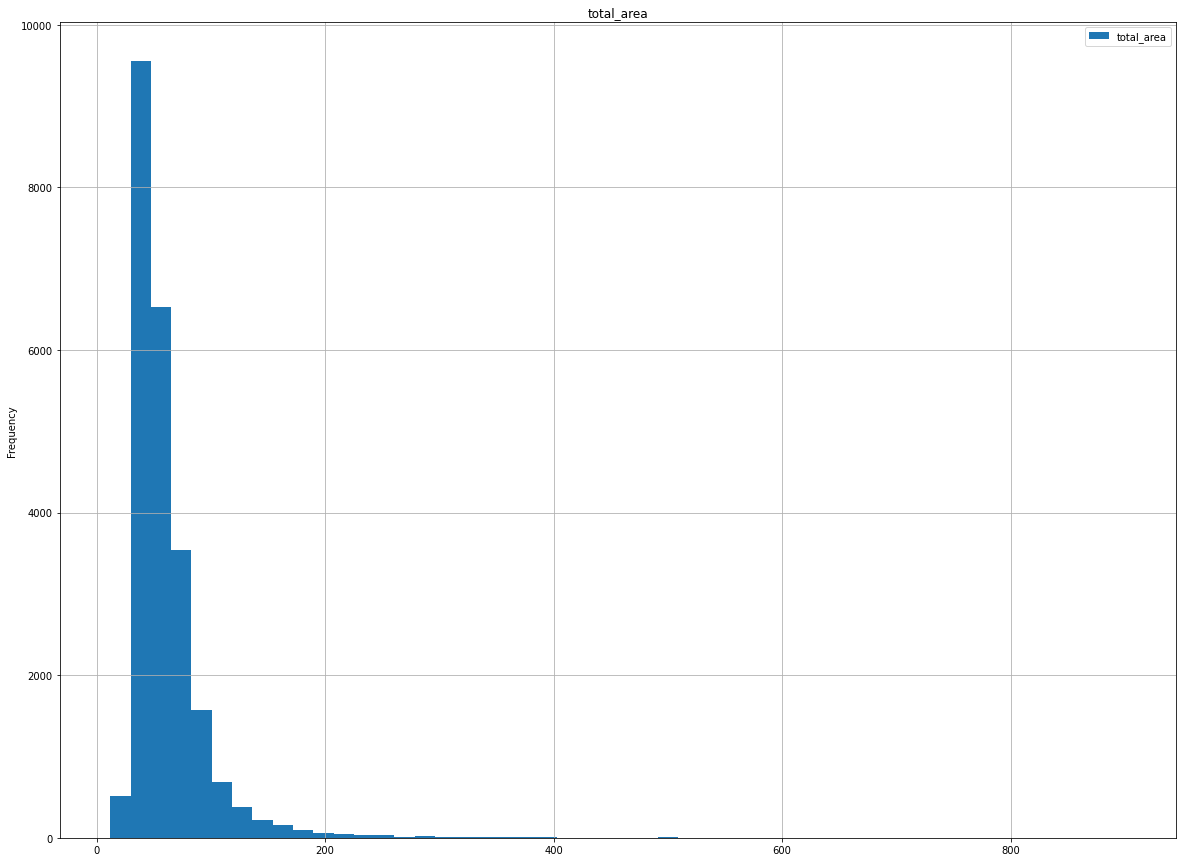

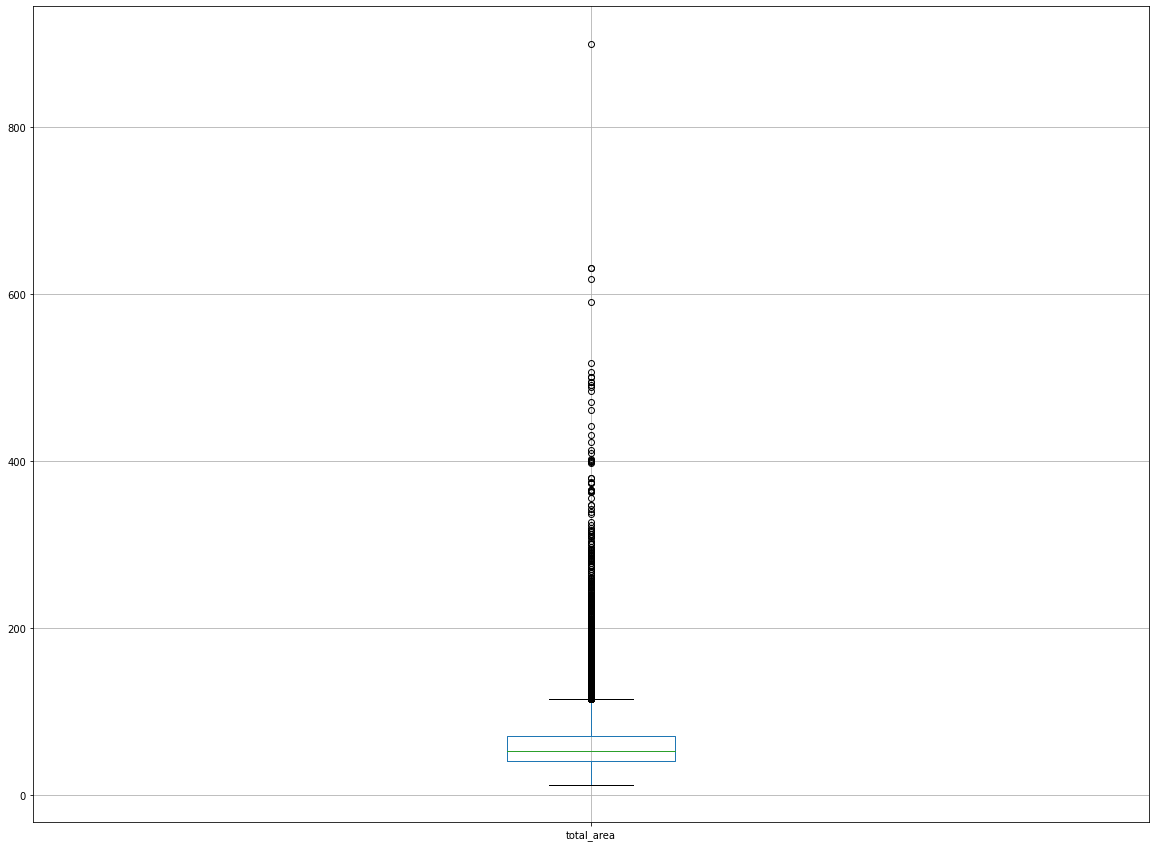

count    23502.000000
mean        60.609079
std         35.610884
min         12.000000
25%         40.200000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64


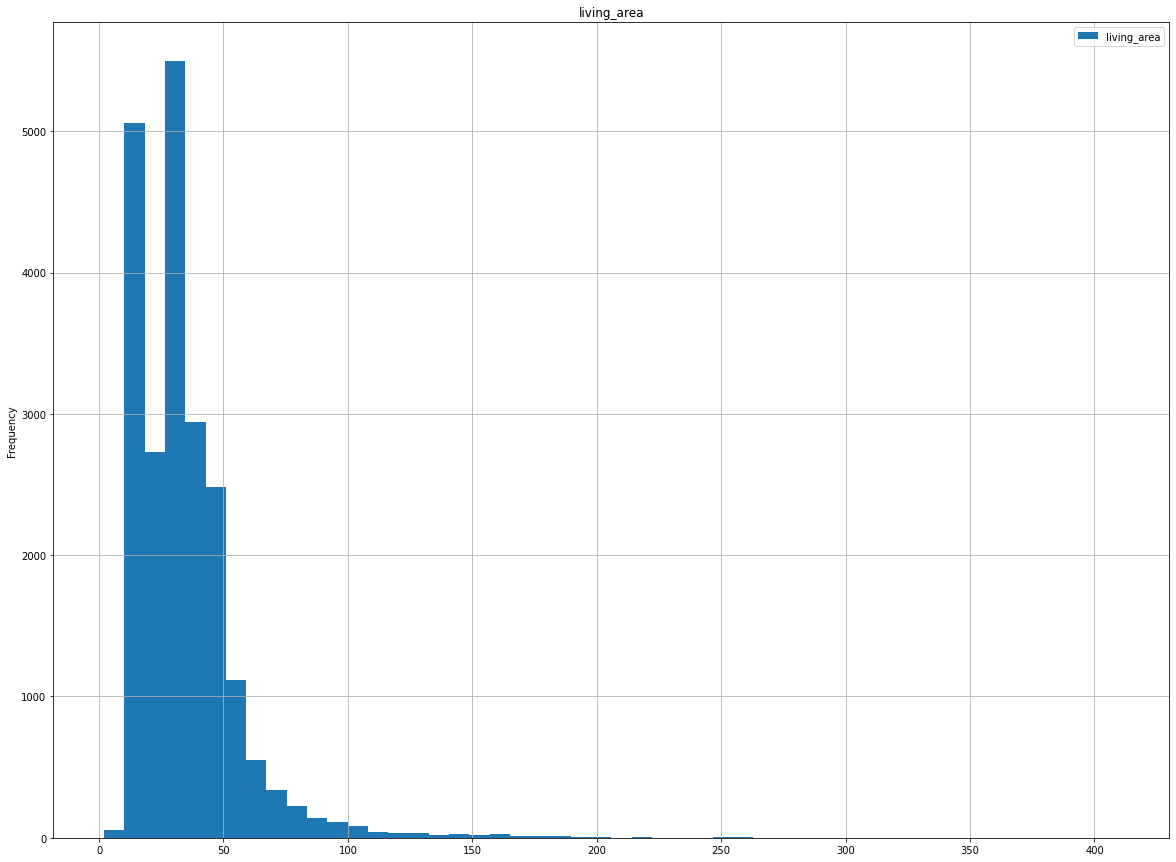

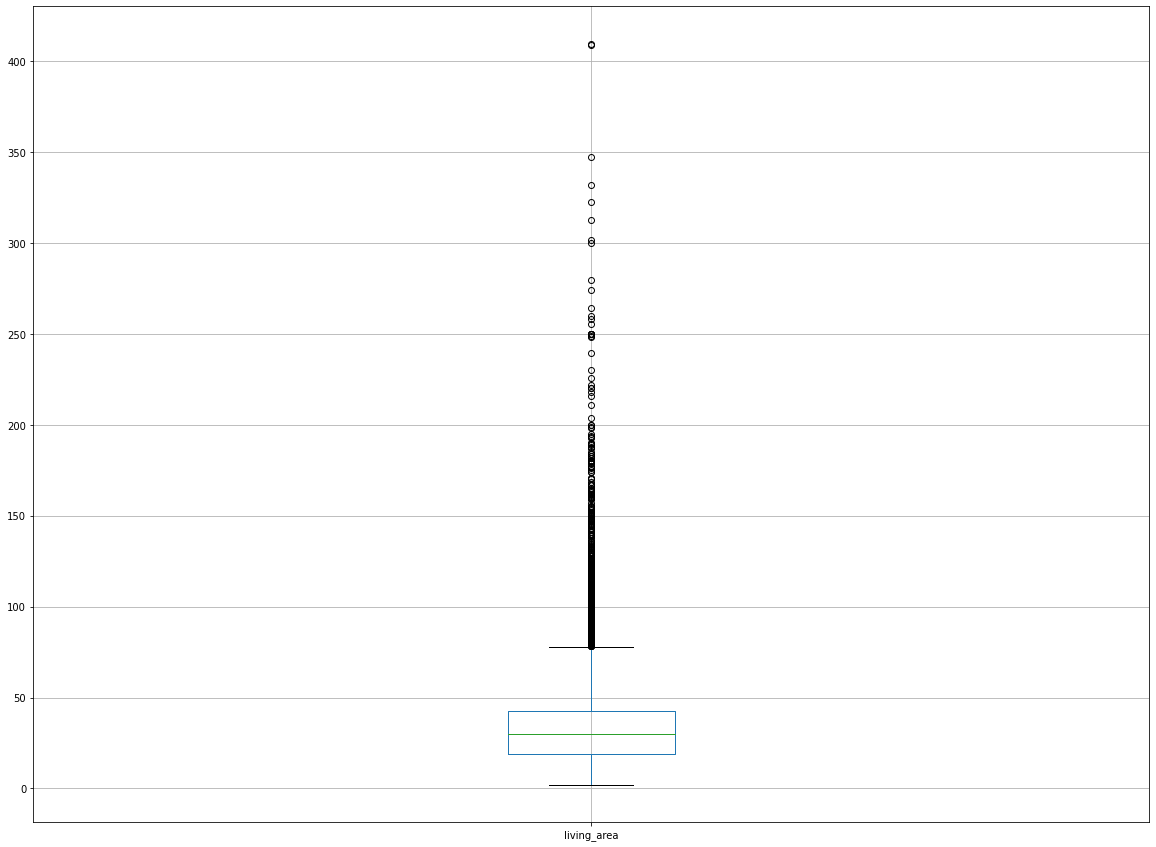

count    21613.000000
mean        34.589877
std         22.068366
min          2.000000
25%         18.700000
50%         30.000000
75%         42.500000
max        409.700000
Name: living_area, dtype: float64


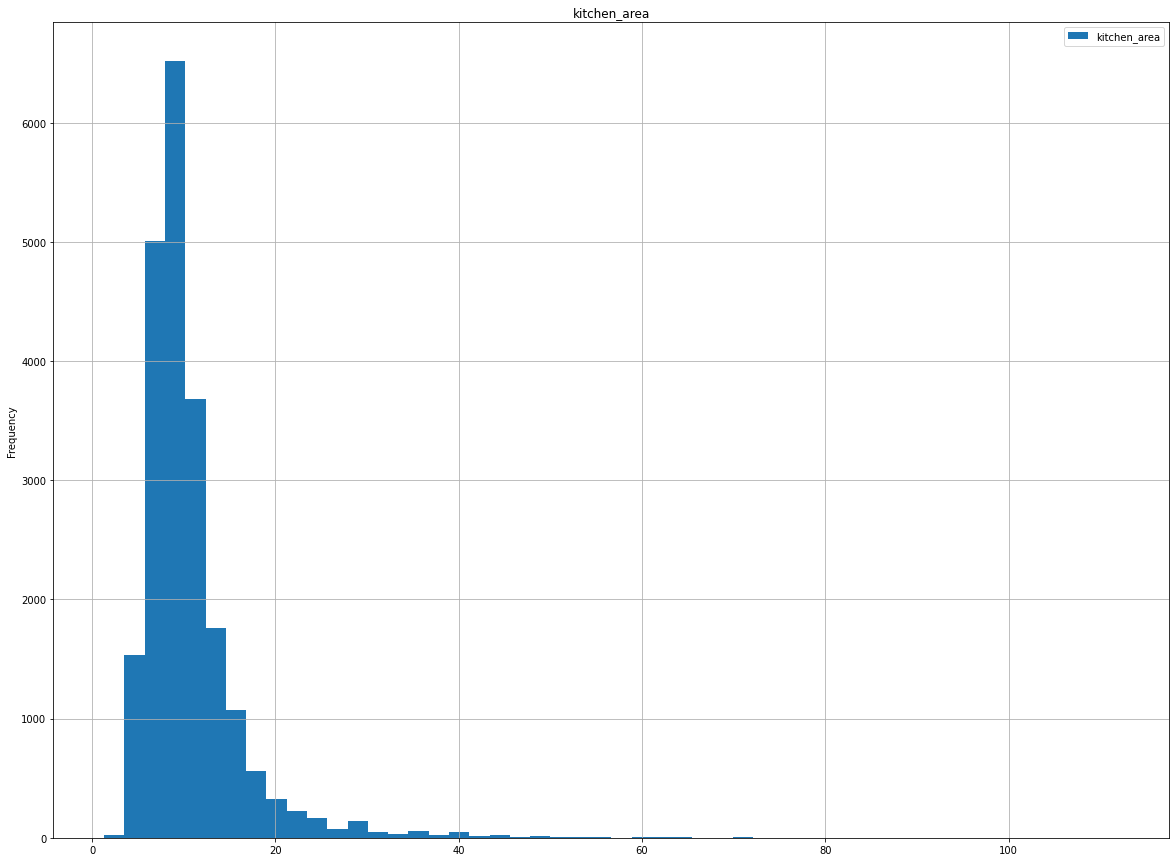

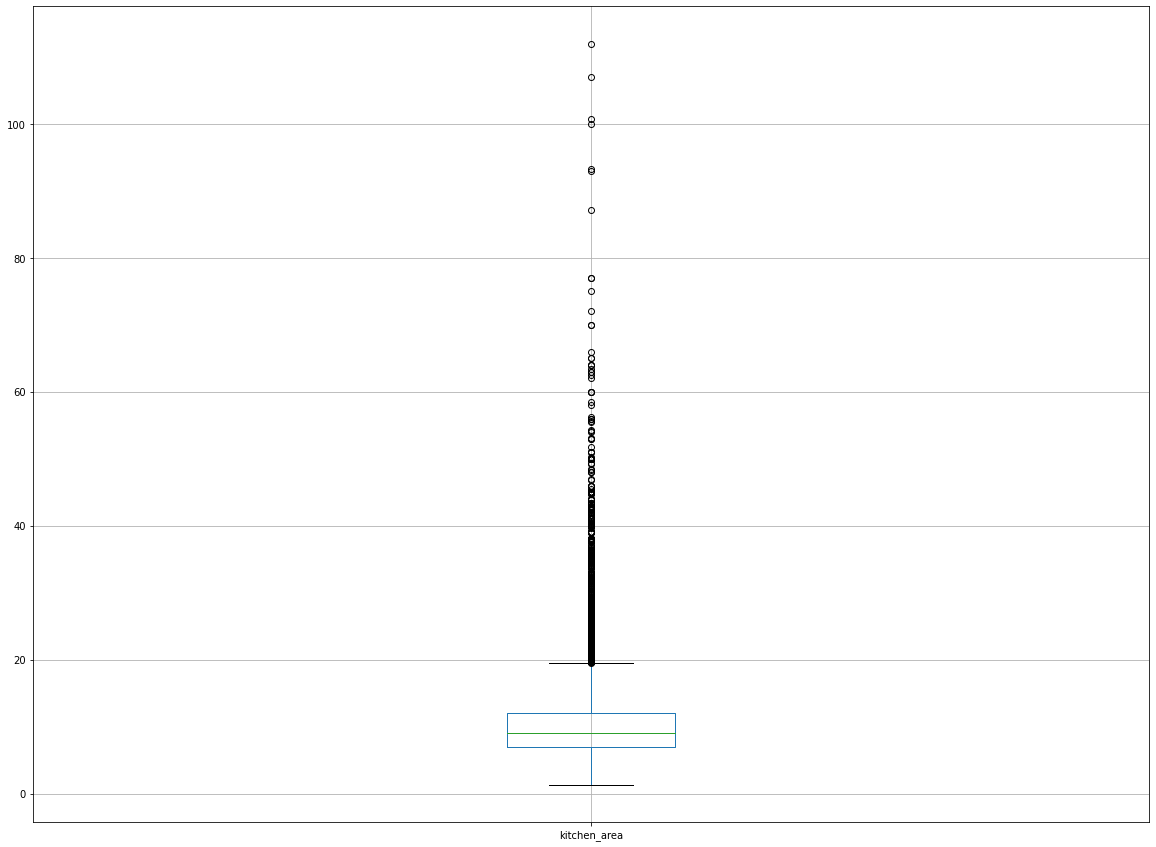

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64


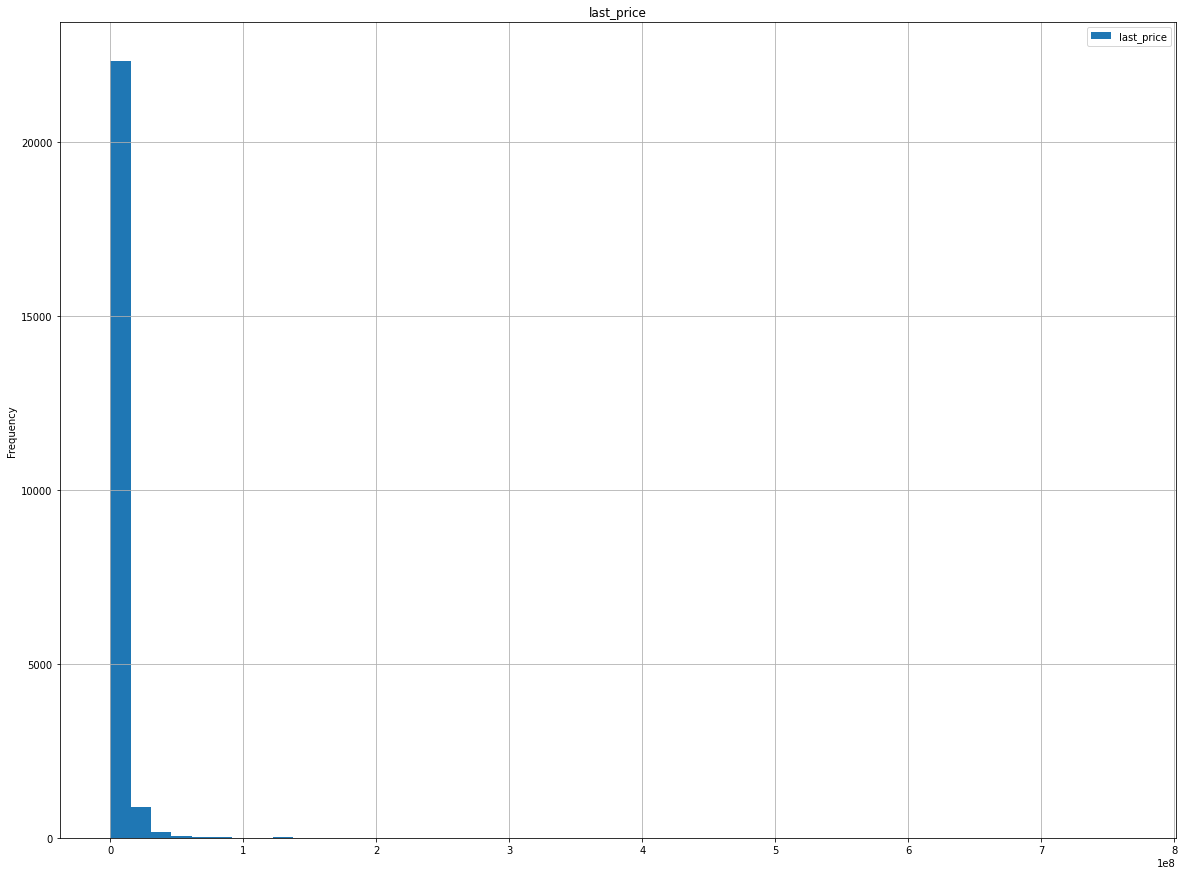

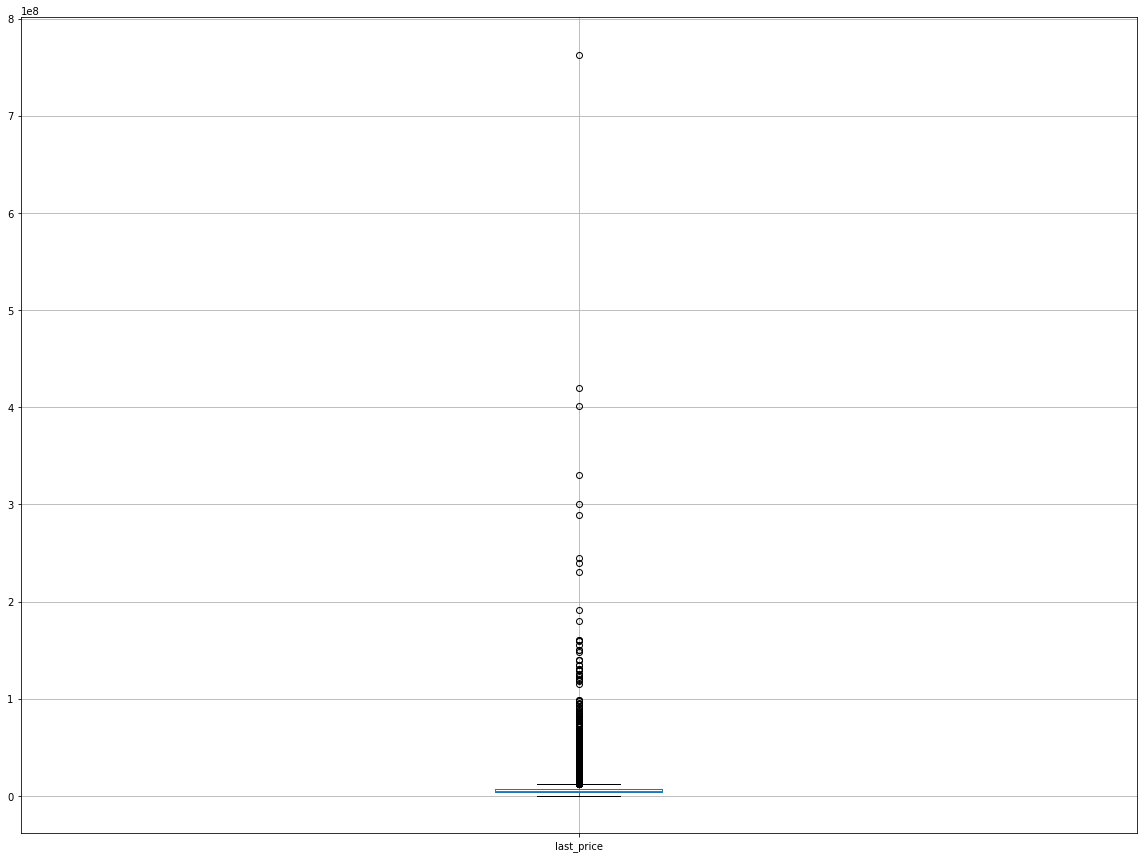

count    2.350200e+04
mean     6.568404e+06
std      1.091886e+07
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


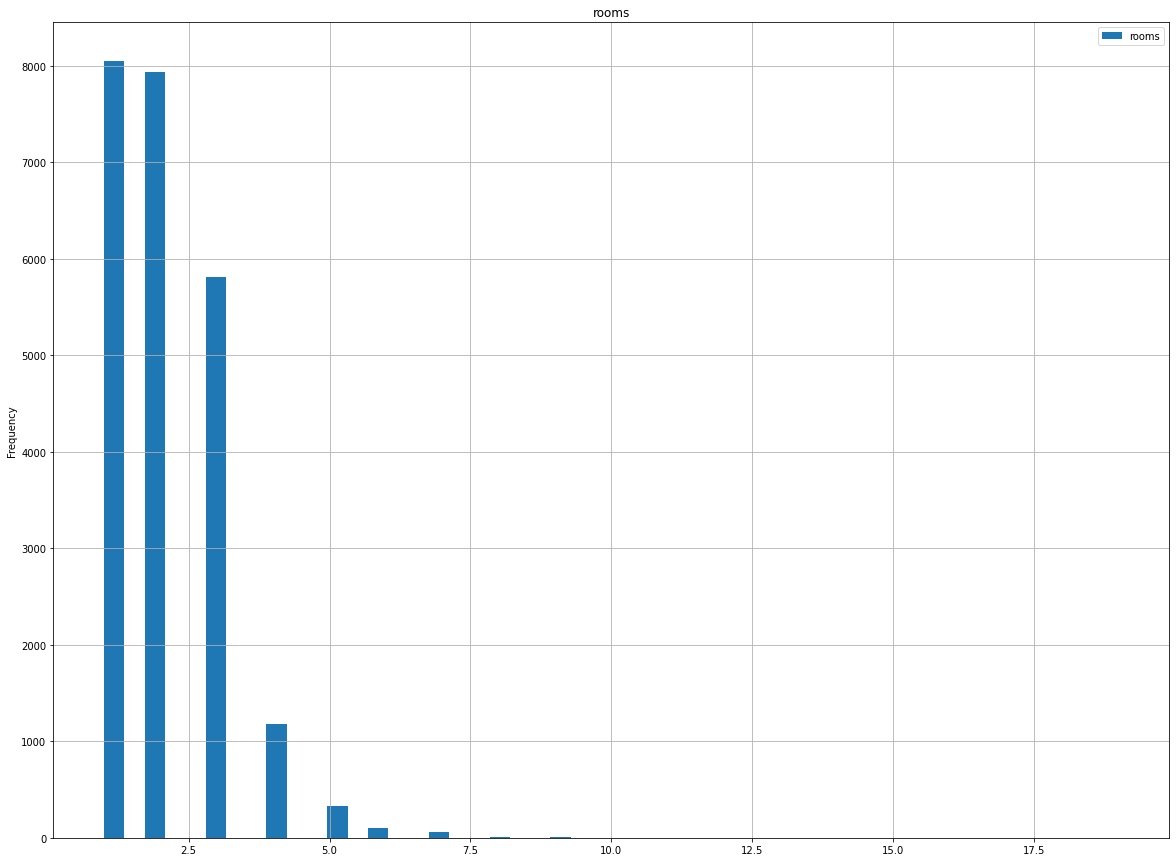

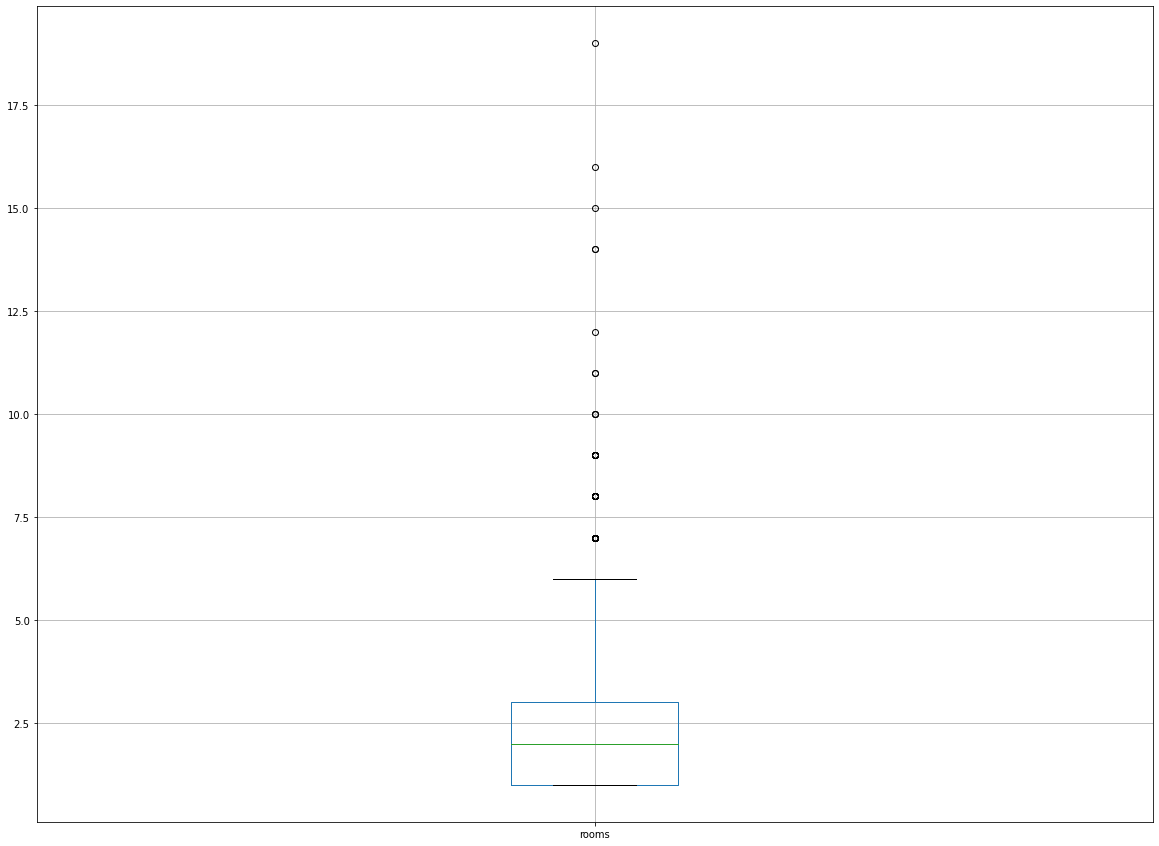

count    23502.000000
mean         2.087993
std          1.066050
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


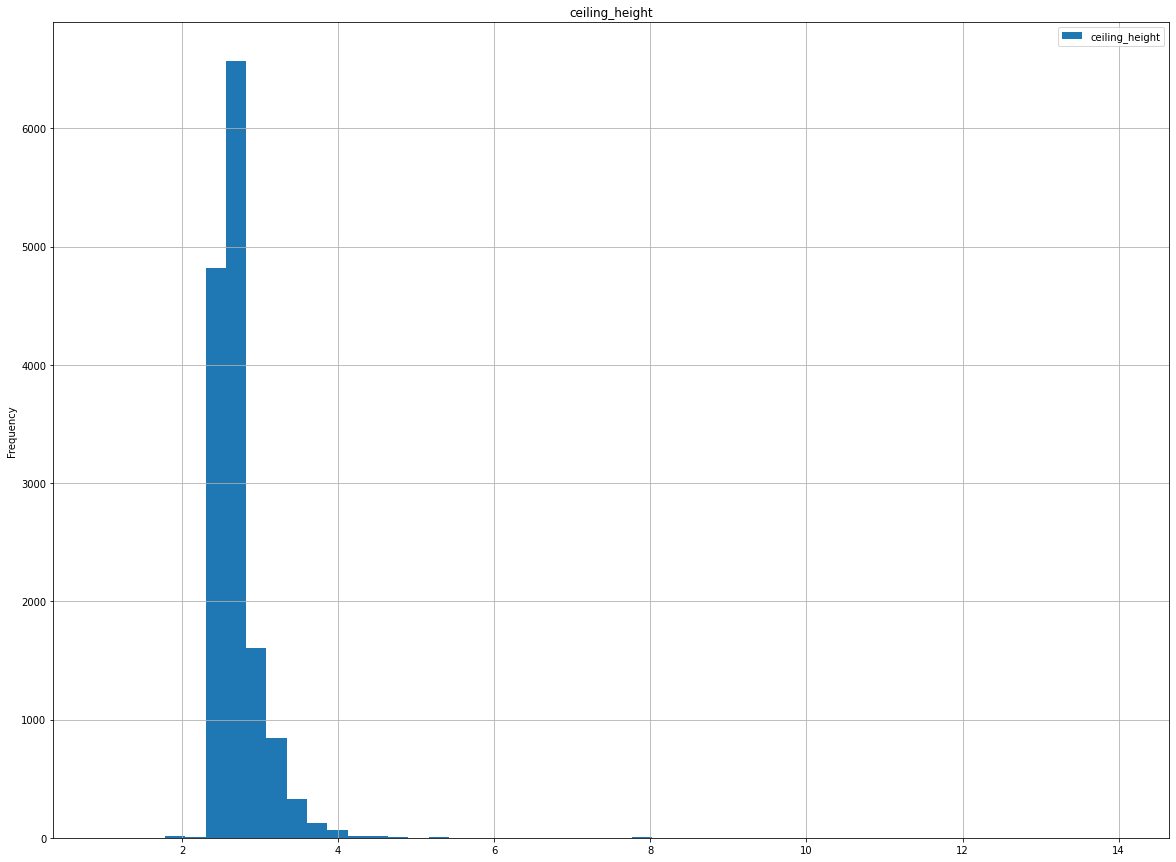

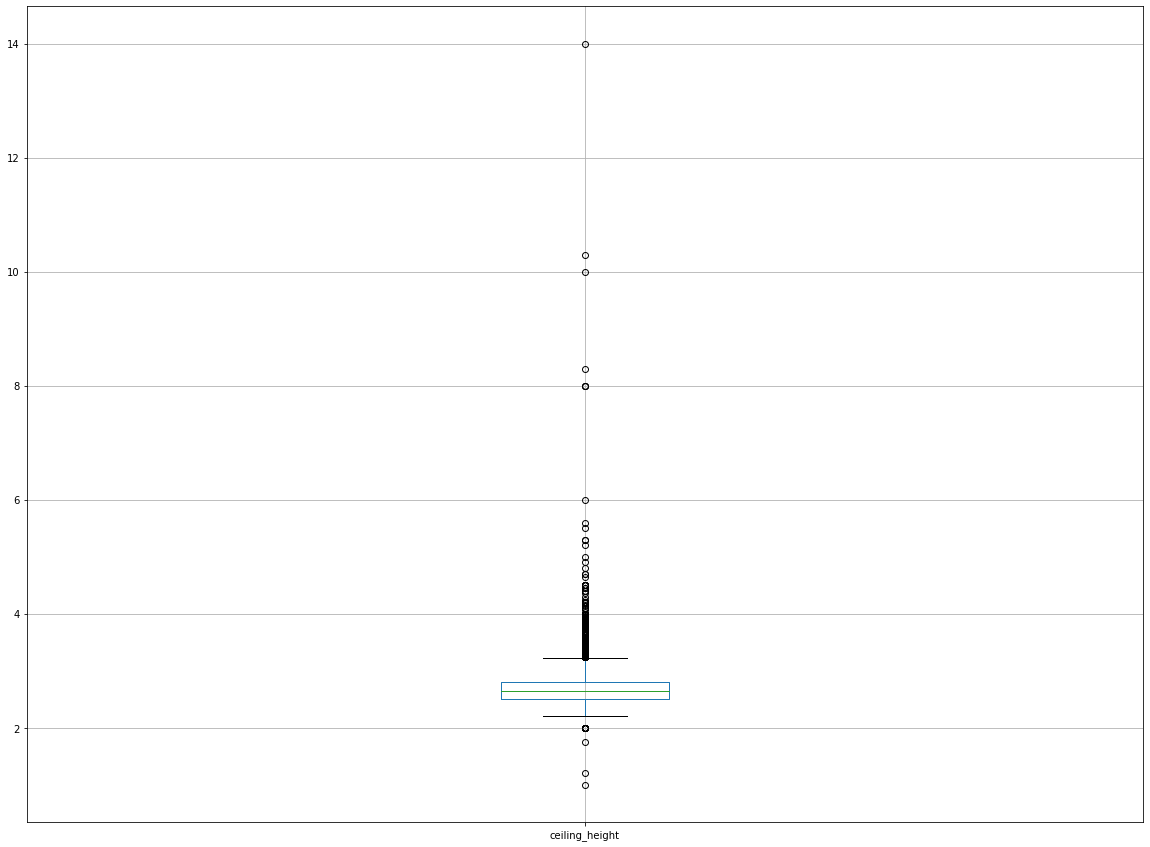

count    14422.000000
mean         2.729162
std          0.319405
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         14.000000
Name: ceiling_height, dtype: float64


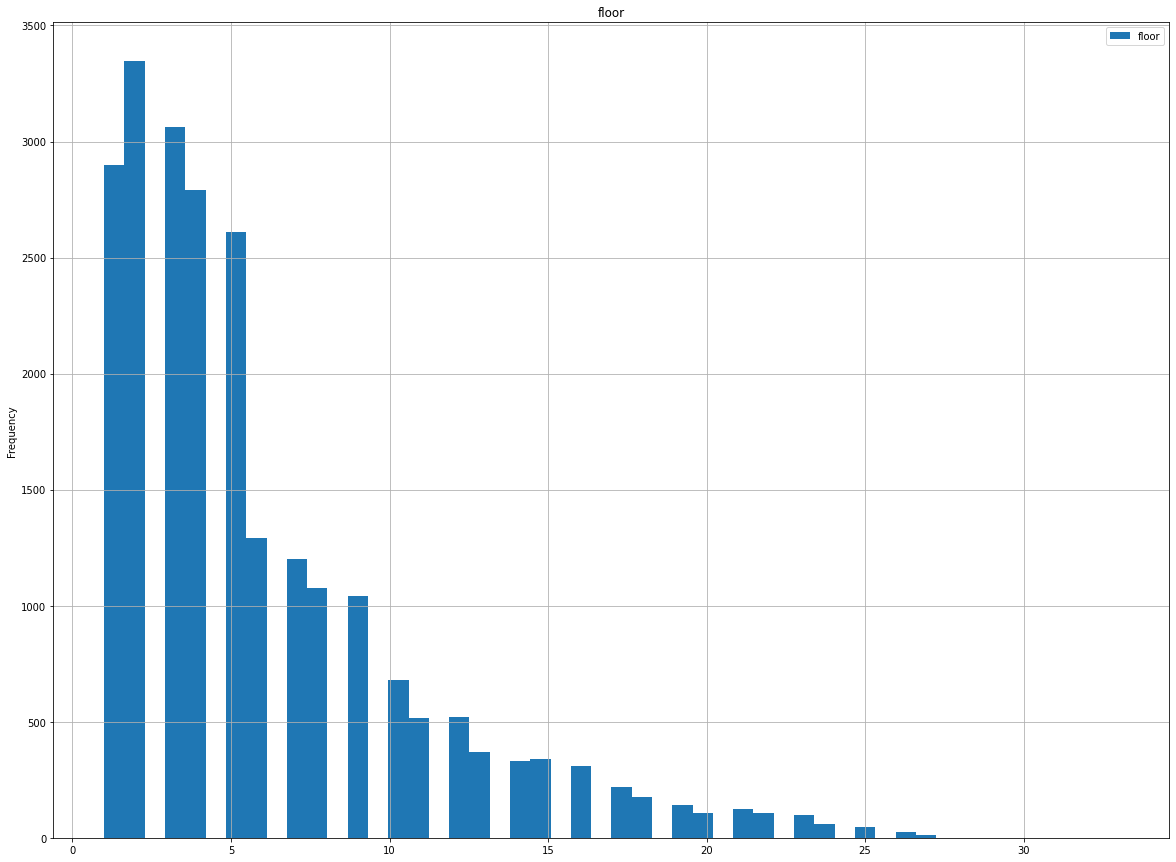

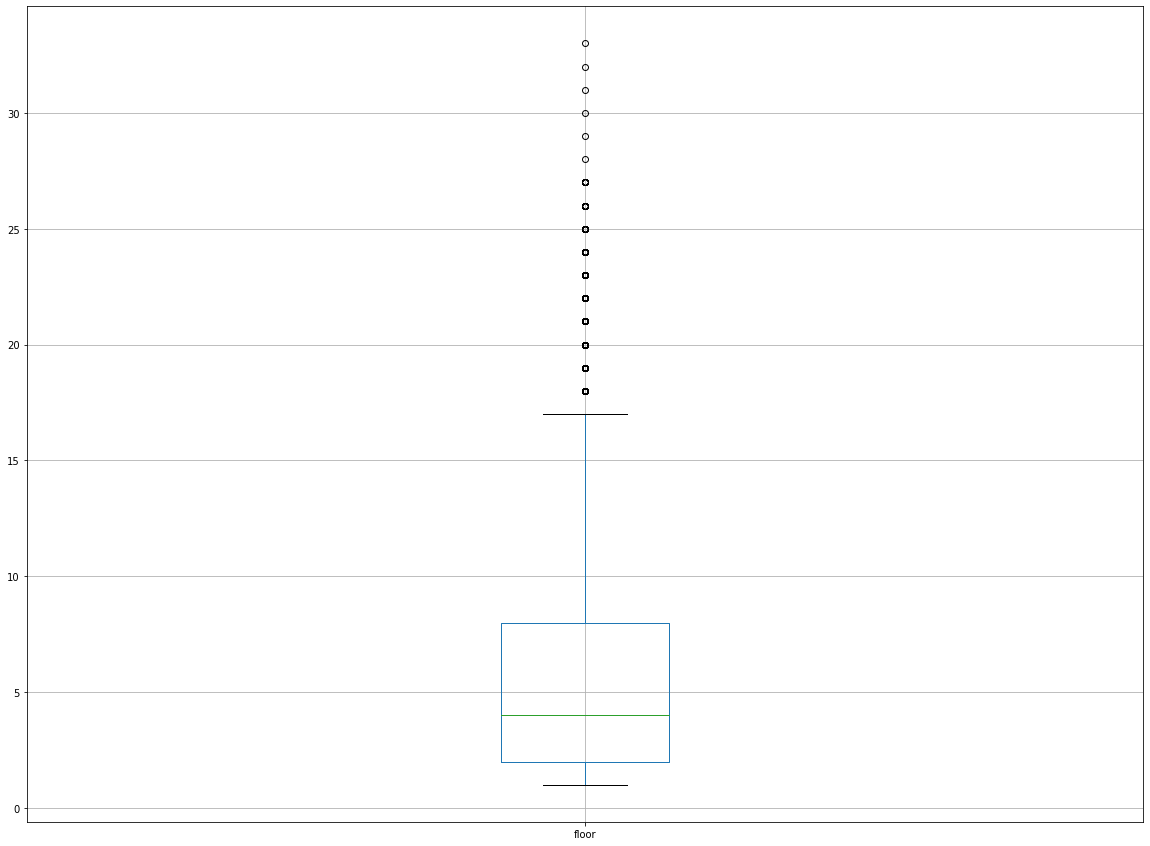

count    23502.000000
mean         5.869841
std          4.865664
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


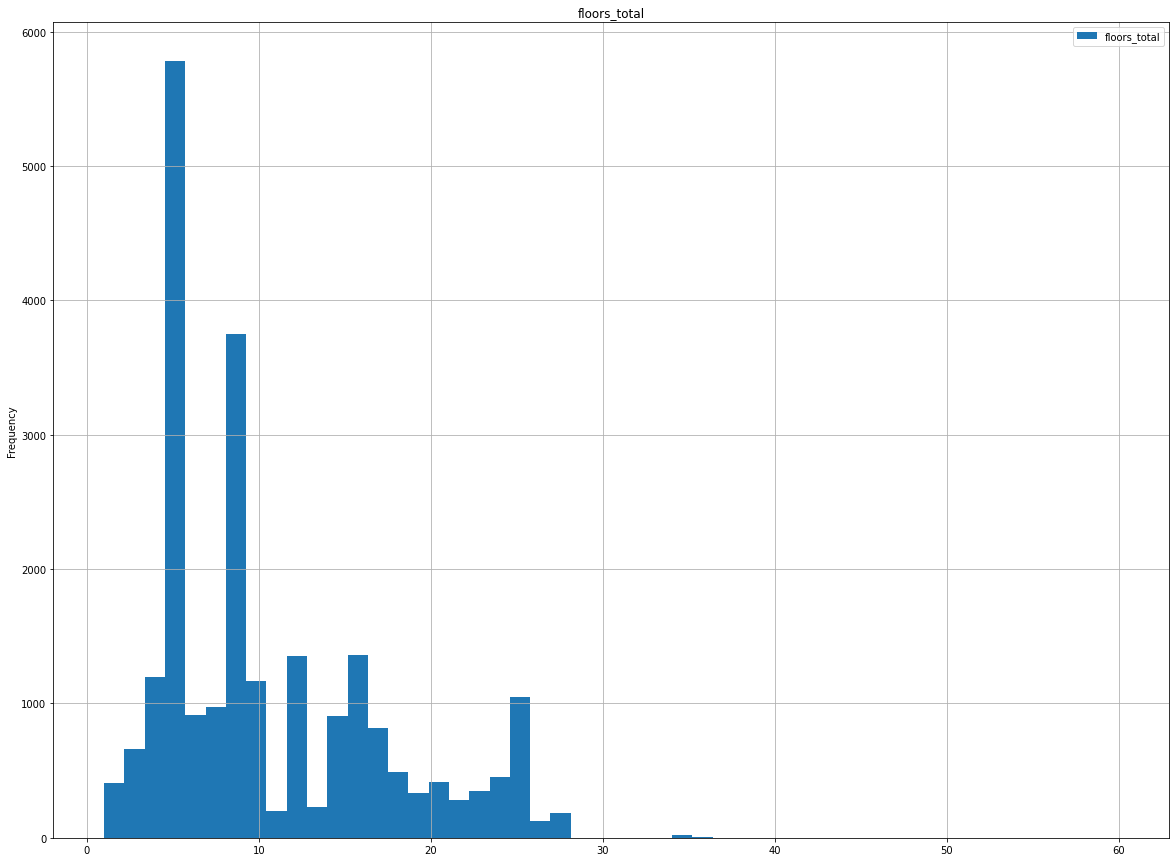

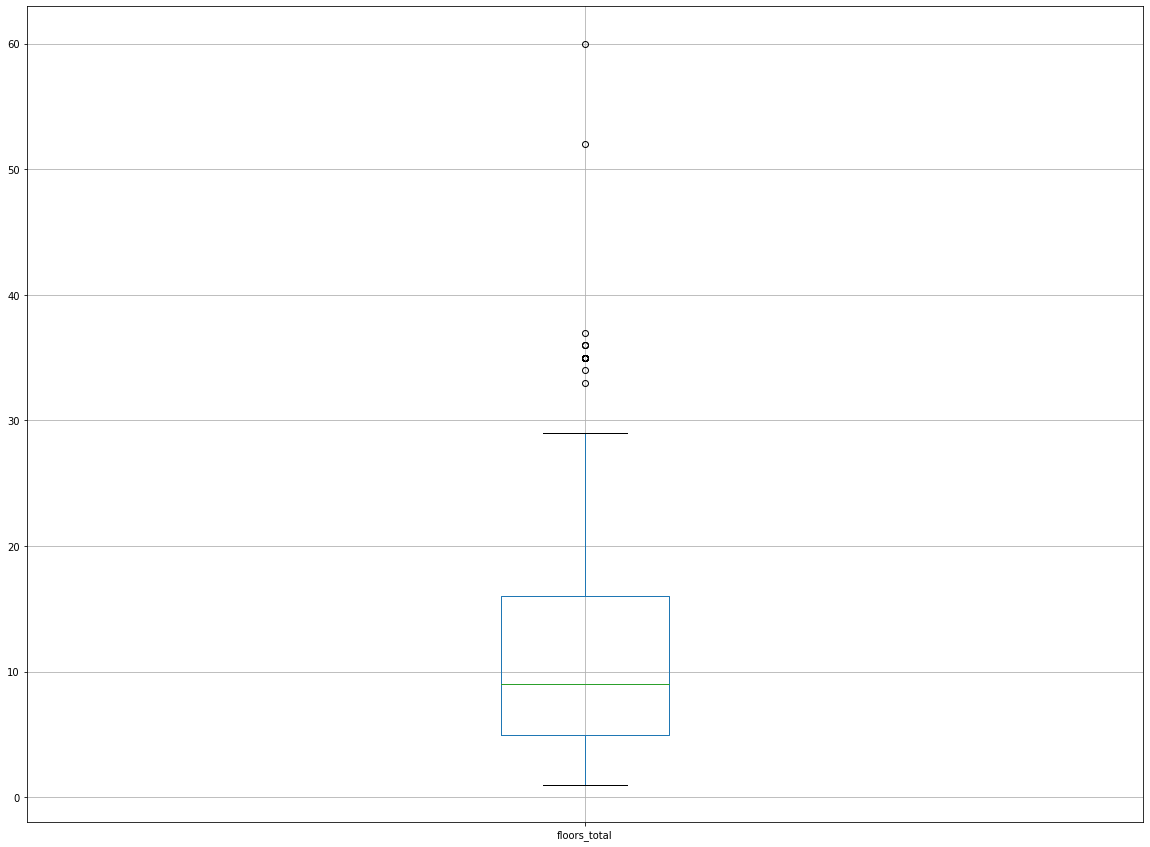

count    23419.000000
mean        10.622273
std          6.569964
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


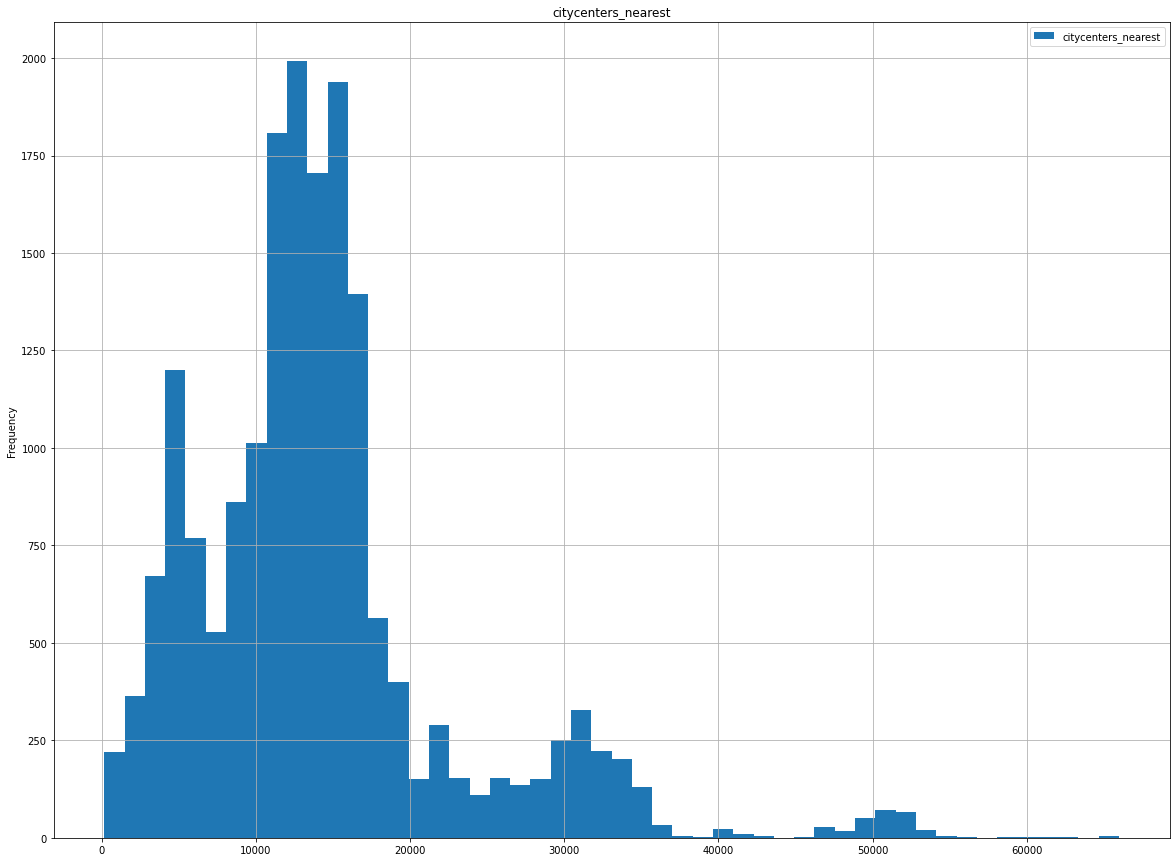

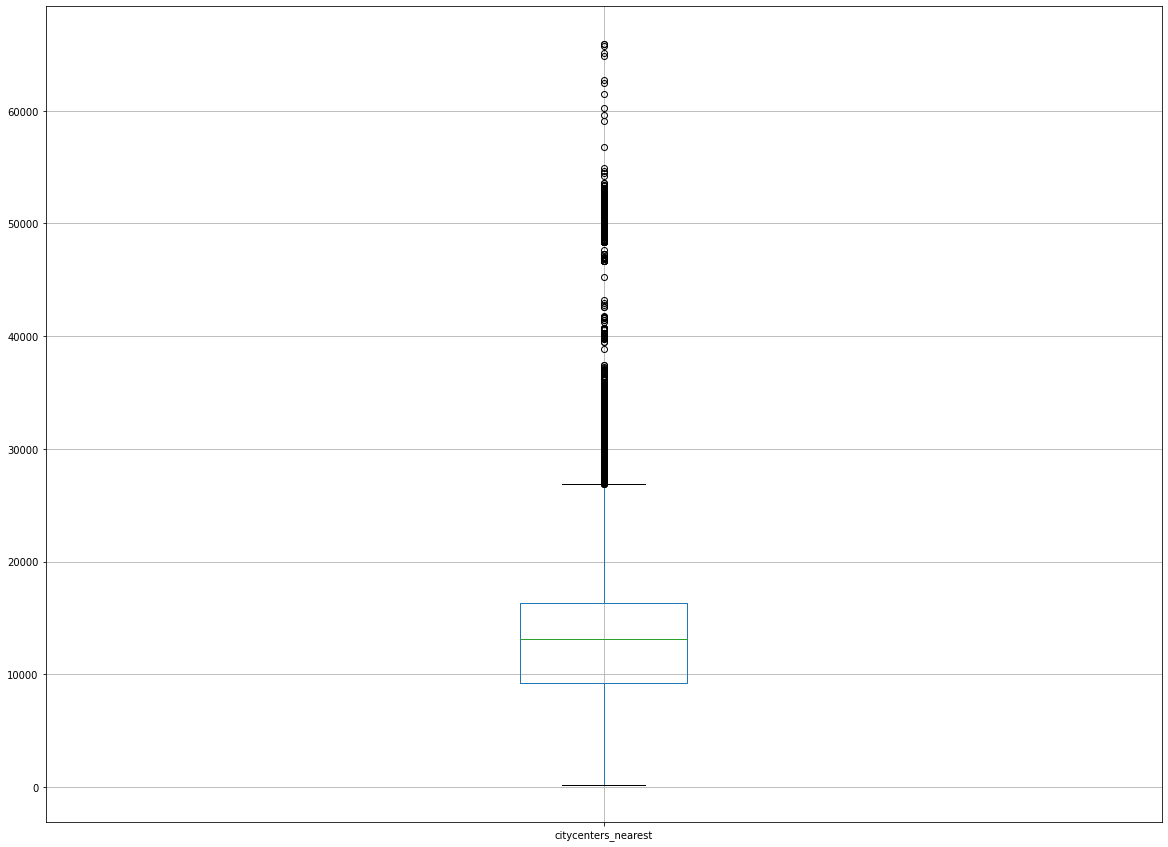

count    18062.000000
mean     14196.521703
std       8626.727604
min        181.000000
25%       9234.000000
50%      13093.000000
75%      16293.000000
max      65968.000000
Name: citycenters_nearest, dtype: float64


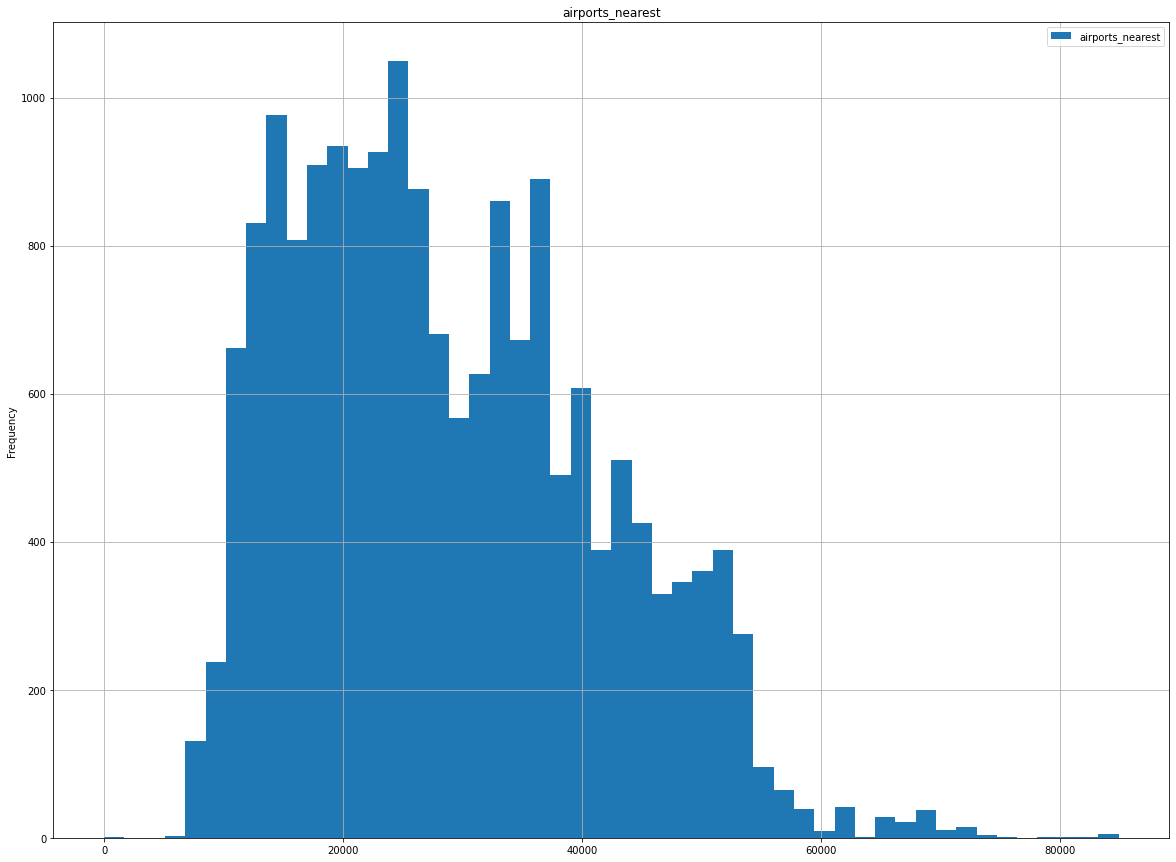

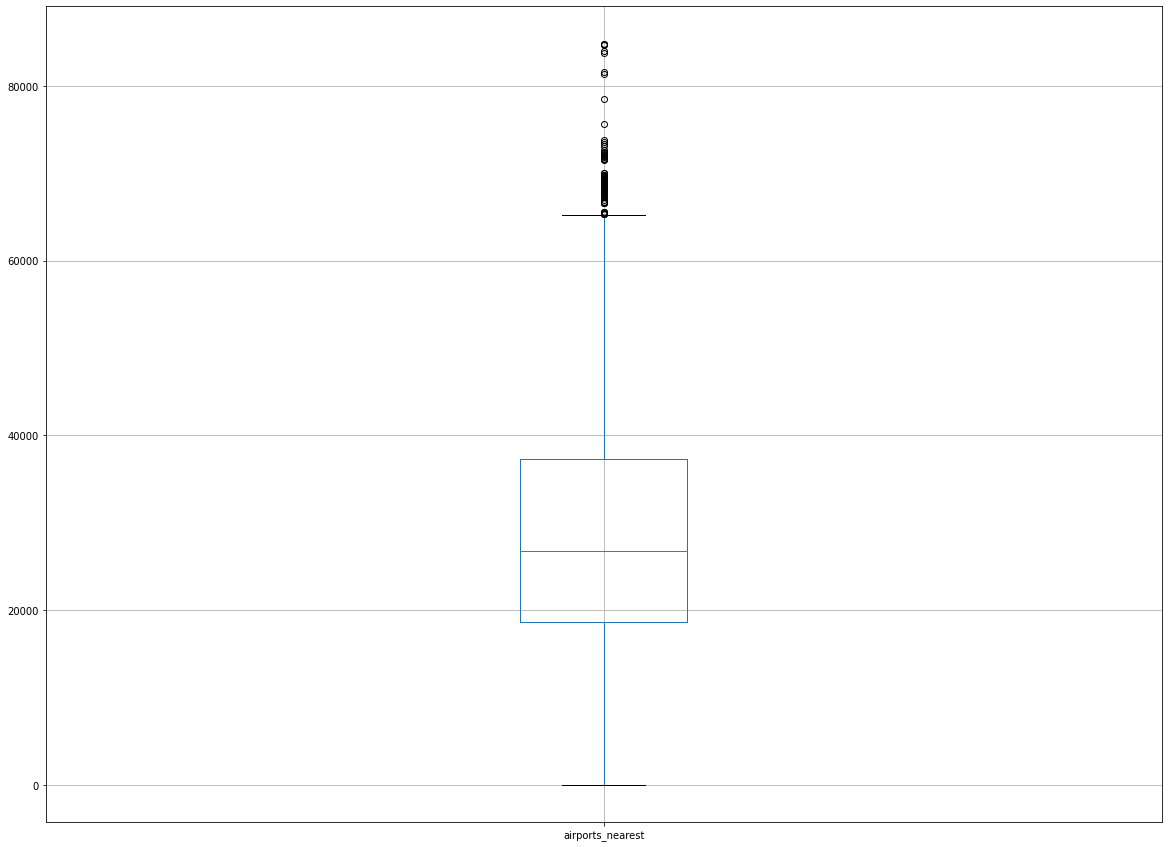

count    18039.000000
mean     28821.651256
std      12628.028646
min          0.000000
25%      18605.500000
50%      26758.000000
75%      37294.000000
max      84869.000000
Name: airports_nearest, dtype: float64


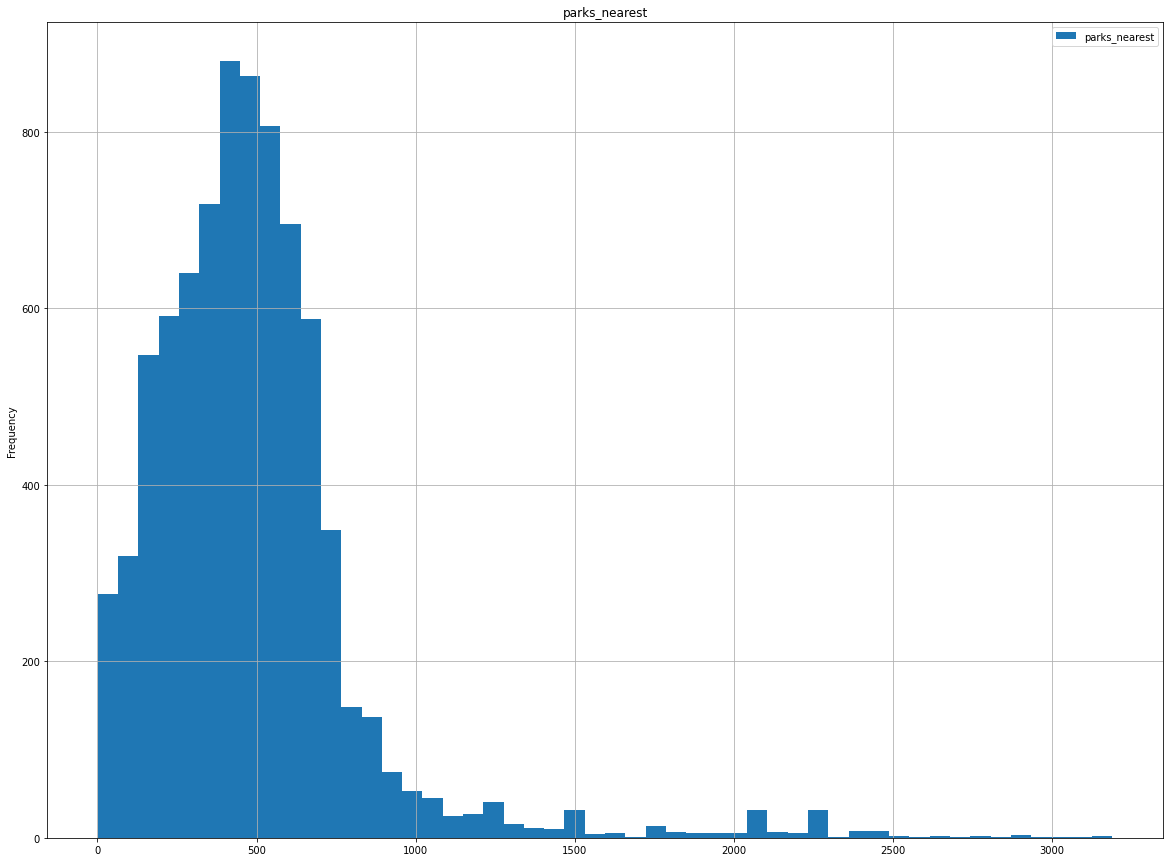

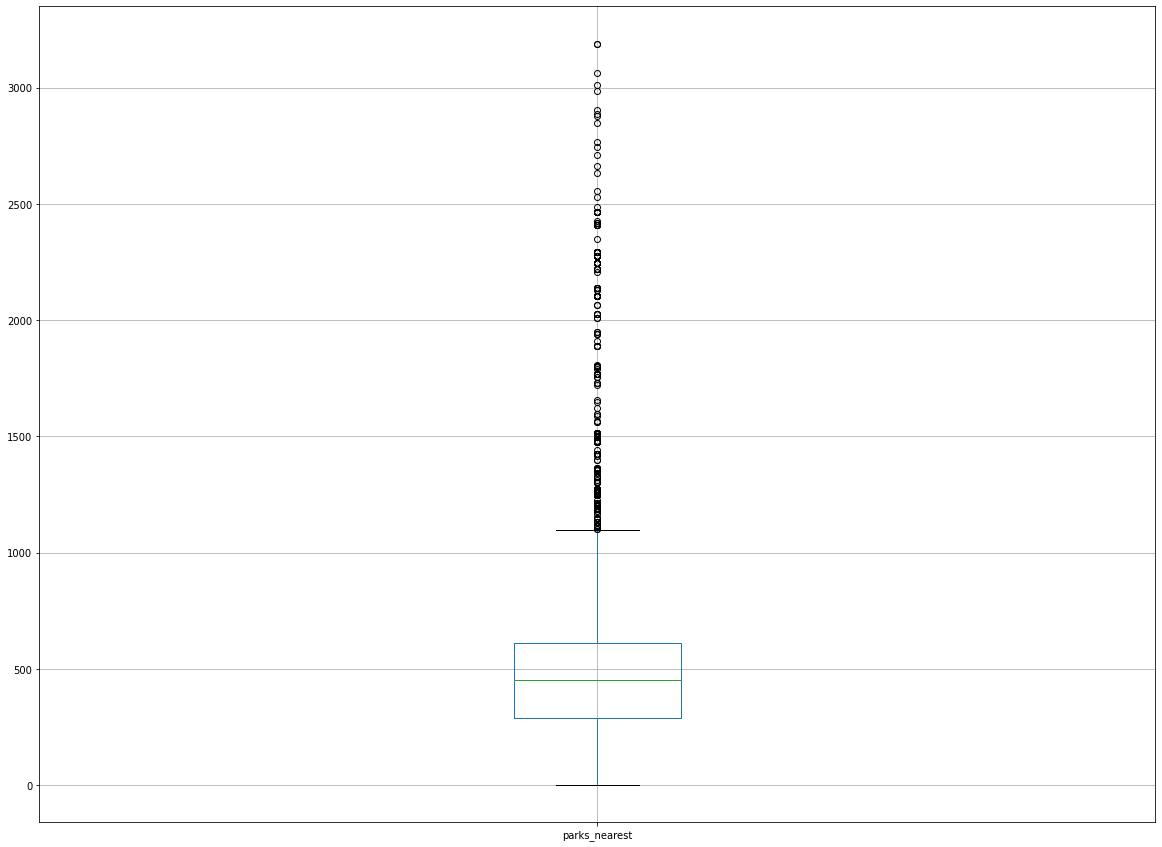

count    8050.000000
mean      490.429689
std       342.411533
min         1.000000
25%       288.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


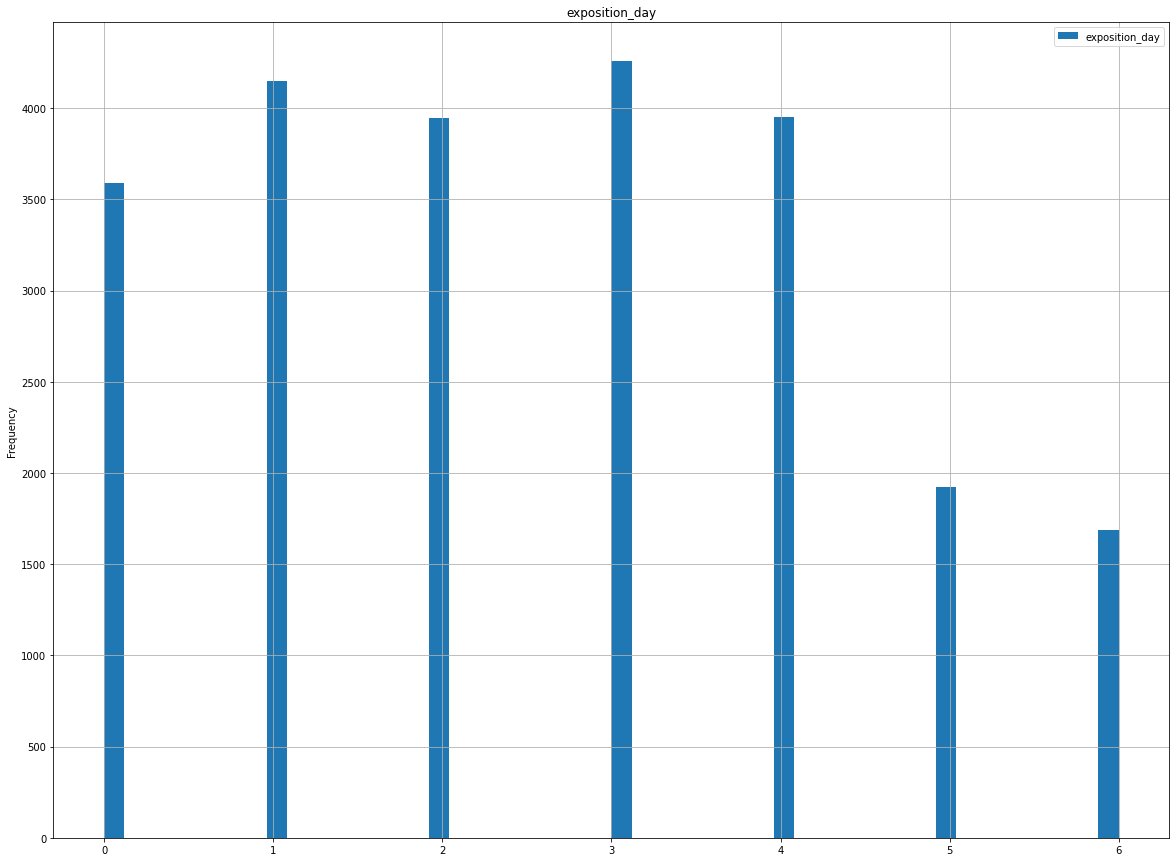

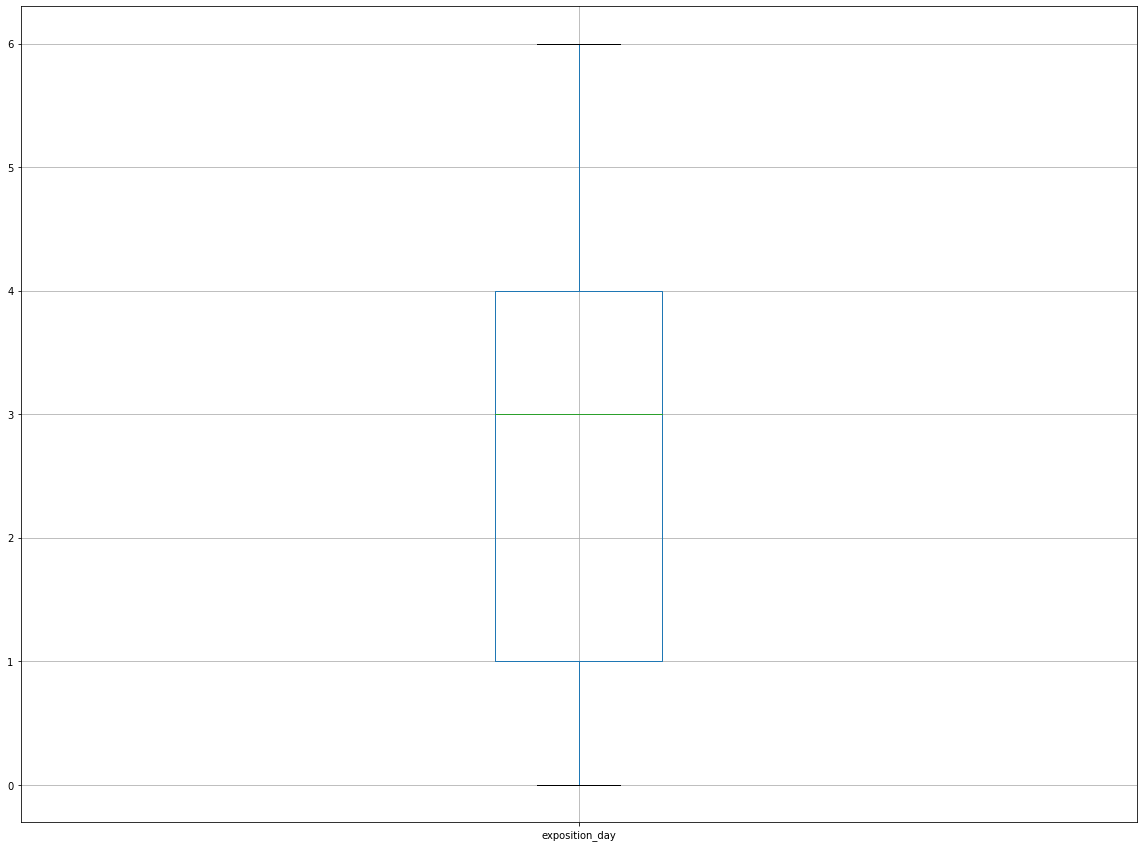

count    23502.000000
mean         2.568079
std          1.790107
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: exposition_day, dtype: float64


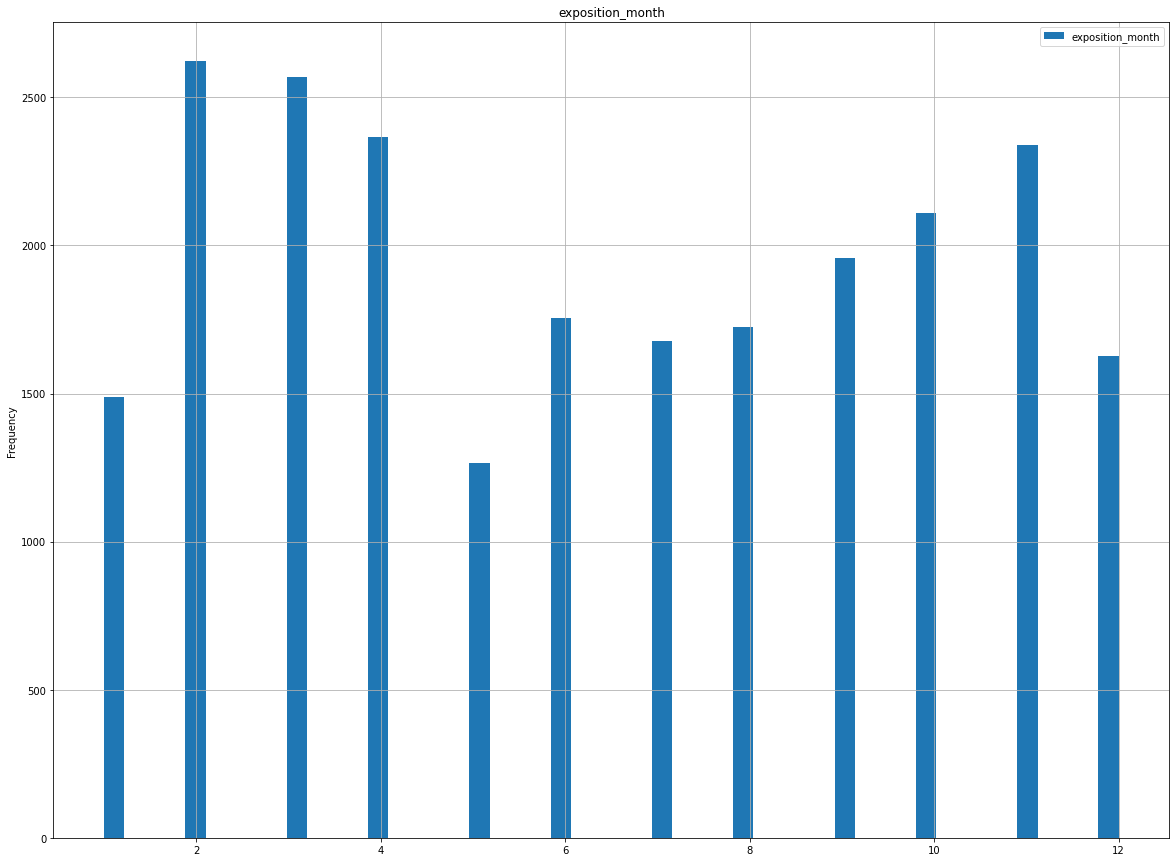

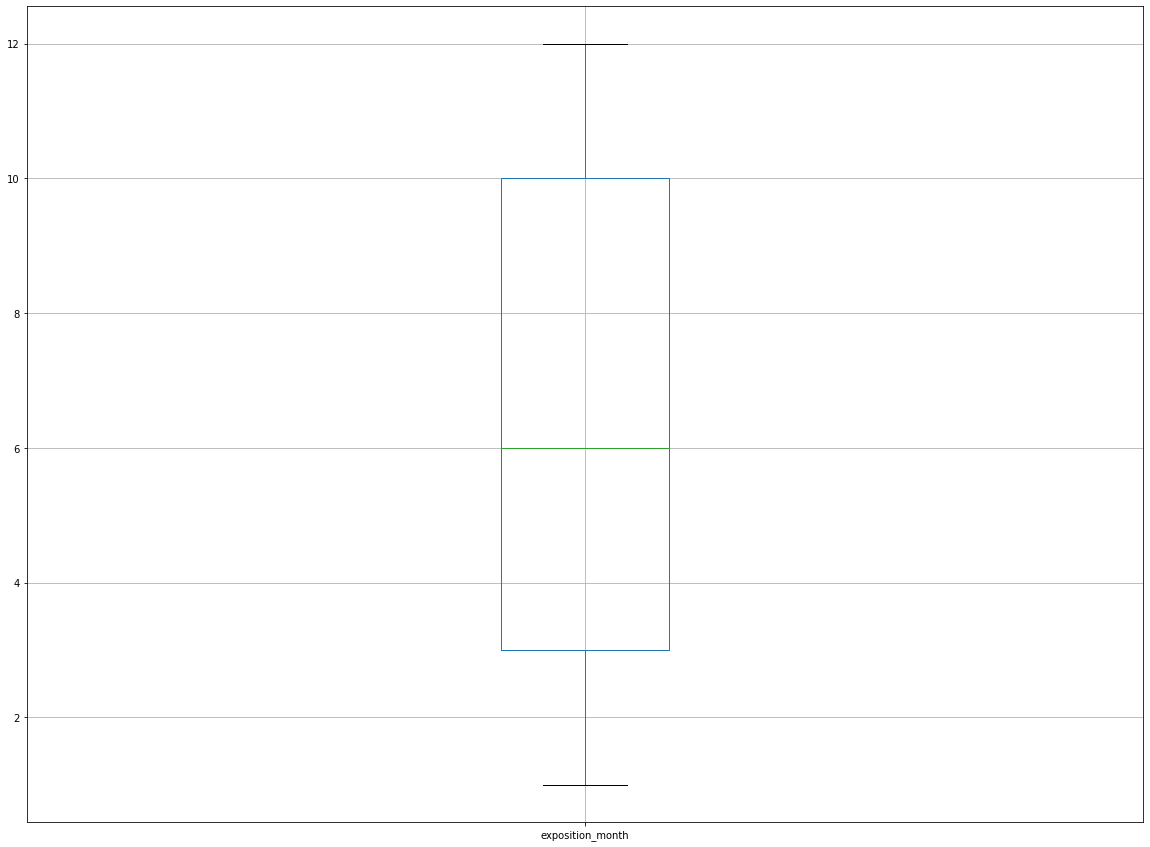

count    23502.000000
mean         6.394052
std          3.490665
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: exposition_month, dtype: float64


In [24]:
hist_params = [
    'total_area',
    'living_area',
    'kitchen_area',
    'last_price',
    'rooms',
    'ceiling_height',
    'floor',
    'floors_total',
    'citycenters_nearest',
    'airports_nearest',
    'parks_nearest',
    'exposition_day',
    'exposition_month'    
]

for param in hist_params:
    df.plot(
        title=param,
        kind='hist',
        y=param,
        bins=50,
        figsize=(20,15),
        grid=True
    )
    plt.show()
    df.boxplot(
        column=param,
        figsize=(20,15),
        grid=True
    )
    plt.show()
    print(df[param].describe())
    

**Вывод:** изучив диаграммы, можно утверждать, что
- общая площадь большинства объектов недвижимости составляет 40-70 квадратных метров;
- жилая площадь большинства объектов недвижимости составляет 18-42 квадратных метра;
- площадь кухни большинства объектов недвижимости составляет 7-12 квадратных метров;
- медианная цена объектов равна 4.65 миллионов рублей;
- среднее количество комнат равно 2;
- средняя высота потолка составляет 2.73 метра;
- большинство квартир занимает со 2 по 8 этаж;
- набор данных представляет собой вторичное жильё малой этажности (5-9 этажей);
- большинство объектов недвижимости удалено от центра на 9-16 км;
- большинство объектов недвижимости удалено от аэоропорта на 19-37 км;
- чуть меньше 20% объектов недвижимости находятся достаточно близко к парку - от 300 до 600 метров;
- объекты недвижимости предпочитают выставлять на продажу в рабочие дни;
- меньше всего выставляют объектов на продажу в следующие месяцы - январь, май и декабрь; неохотно выставляют квартиры в июне, июле и августе; а больше всего предложений продажи появляется в феврале, марте и апреле.

### Как быстро продавались квартиры?

Изучим, как быстро продавались квартиры (`days_exposition`). 
Построим гистограмму, диаграмму размаха; посчитаем среднее и медиану.

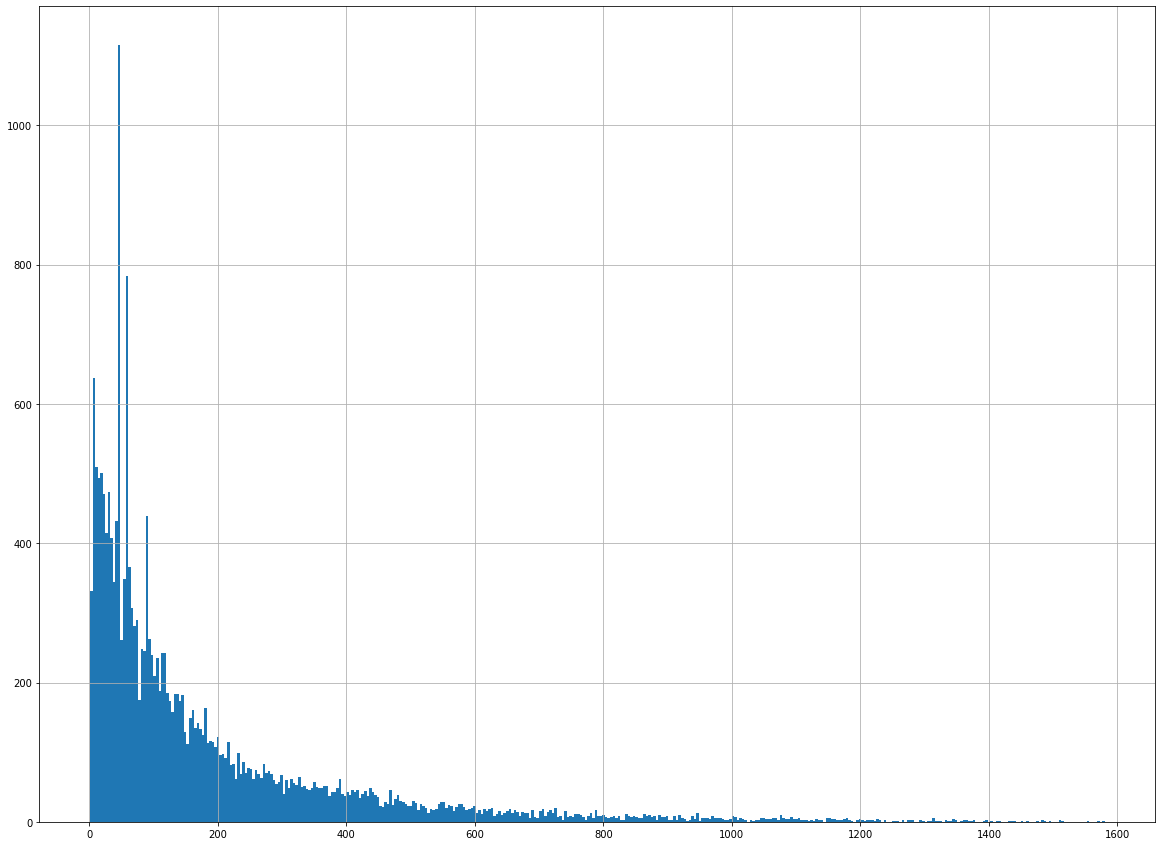

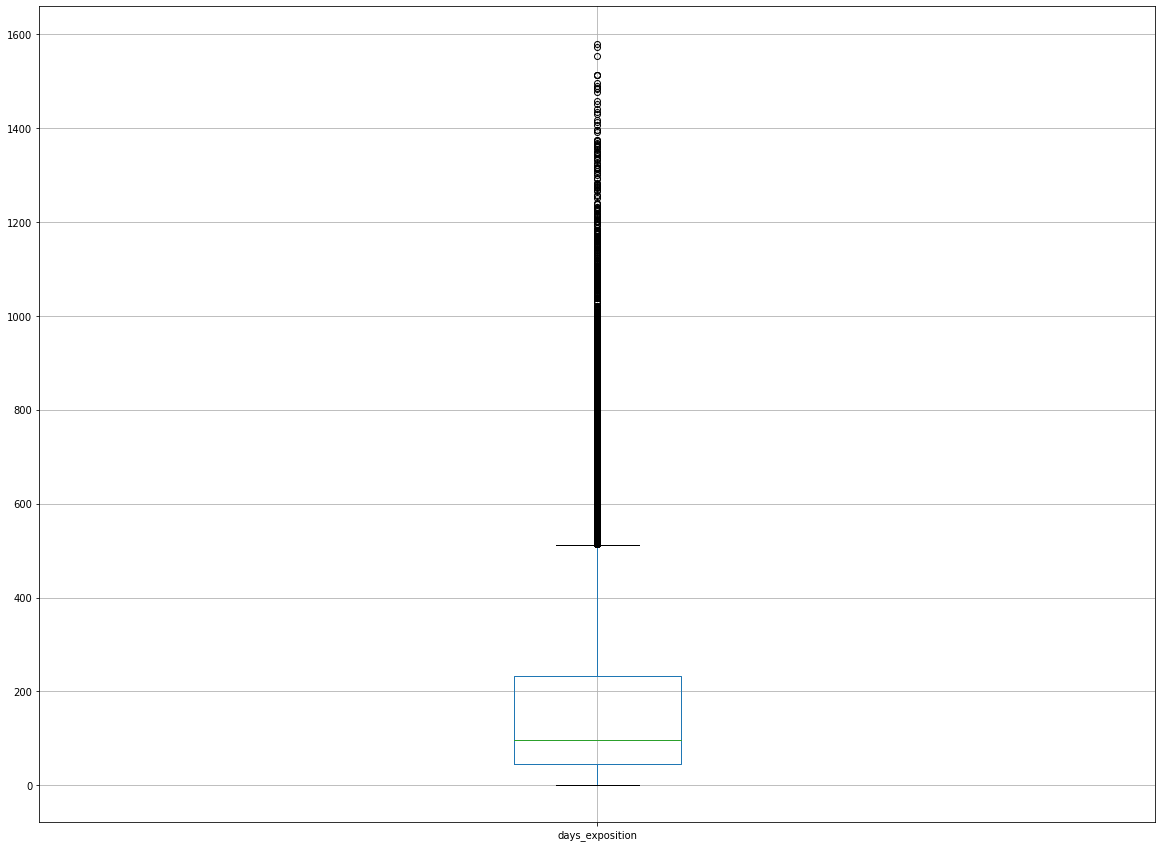

count    20335.000000
mean       181.533956
std        220.096252
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


In [25]:
df['days_exposition'].hist(bins=400, figsize=(20, 15))
plt.show()
df.boxplot(column=['days_exposition'], figsize=(20, 15))
plt.show()
print(df['days_exposition'].describe())

На графике видны странные пики в диапазоне 0-120 дней. Увеличим масштаб и взглянем поближе на эти пики.

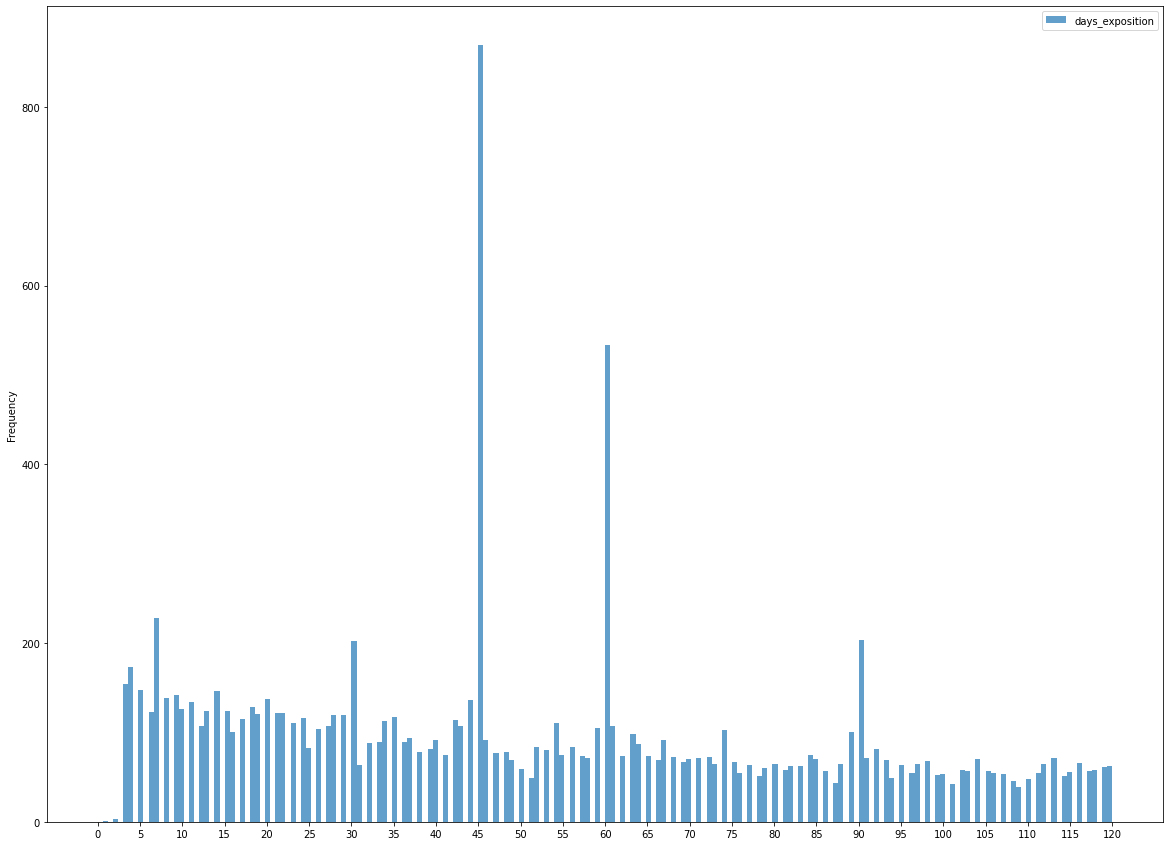

In [26]:
ax=df.plot(
    kind='hist',
    y='days_exposition',
    range=(0, 120),
    bins=200,
    linewidth=5,
    alpha=0.7,
    figsize=(20, 15))

ax.set_xticks(list(range(0,125,5)))

plt.show()

Итак, это пики продаж на 7 дней, 30, 45, 60 и 90 дней. Такое может быть объяснено договорами собственников квартир с риэлторскими агентствами срочного выкупа. Смысл в том, что агентство за определённое количество дней обязуется реализовать недвижимость, а если не получается - выкупает жильё за цену ниже рыночной.

**Вывод:** в среднем, продажа обычно занимает 96 дней (медианное значение) - 50% квартир из набора данных были проданы именно за 96 дней. Быстрыми можно считать продажи длительностью меньше 1.5 месяцев. Долгими продажами являются от 232 до 500 дней; и аномально долгими - больше 500. Также мы обнаружили характерные для риэлторских агентств пики продаж в 7, 30, 45, 60 и 90 дней - случаи срочного выкупа жилья у собственников.

### Какие факторы больше всего влияют на общую стоимость объекта?

#### Зависимость цены от площади и количества комнат

Изучим, зависит ли цена (`last_price`) от:
- общей площади (`total_area`);
- жилой площади (`living_area`);
- площади кухни (`kitchen_area`);
- количества комнат (`rooms`).
Посчитаем для этих параметров коэффициент корреляции Пирсона и построим диаграммы рассеяния.

In [27]:
corr_params = [
    'total_area',
    'living_area',
    'kitchen_area',
    'rooms'
]

for param in corr_params:
    print(f'Корреляция между last_price и {param} равна {df["last_price"].corr(df[param])}.')

Корреляция между last_price и total_area равна 0.6531162323425471.
Корреляция между last_price и living_area равна 0.5660247789274262.
Корреляция между last_price и kitchen_area равна 0.5198690130216392.
Корреляция между last_price и rooms равна 0.36473613698747404.


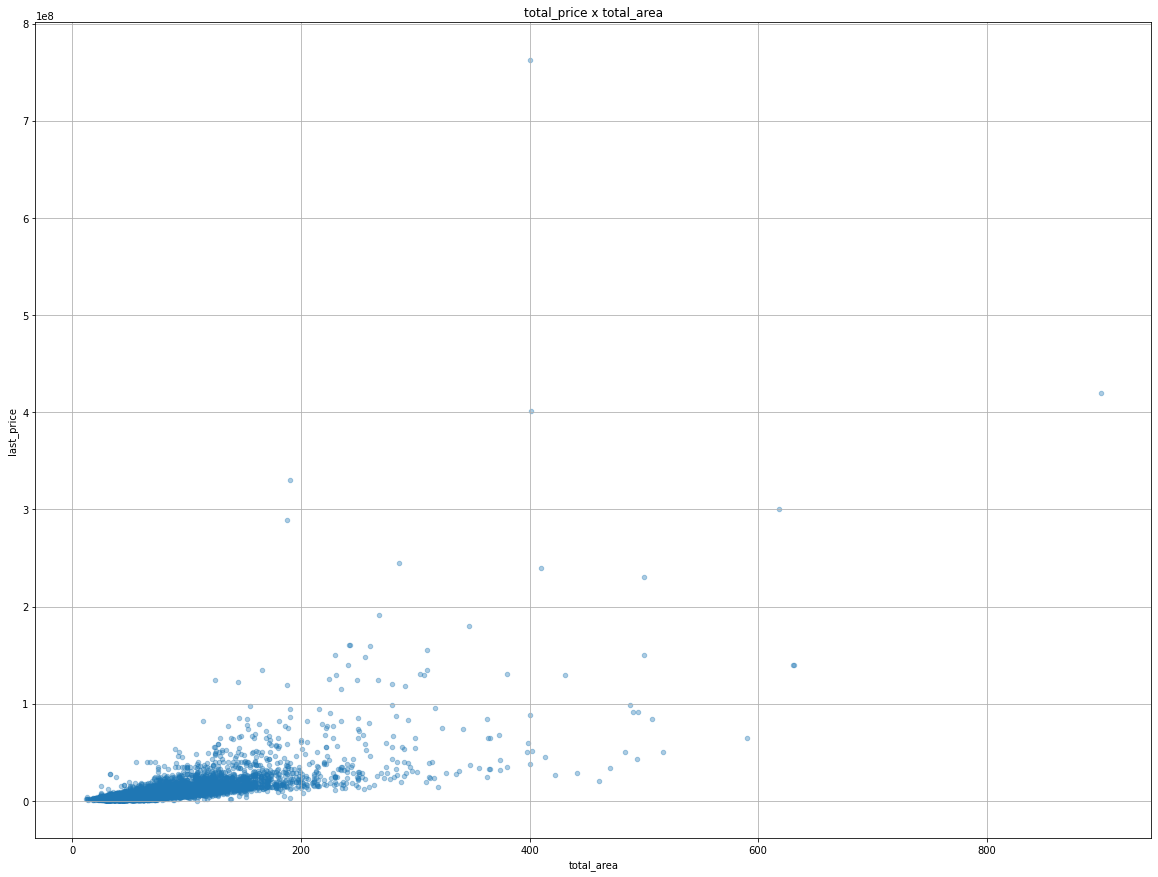

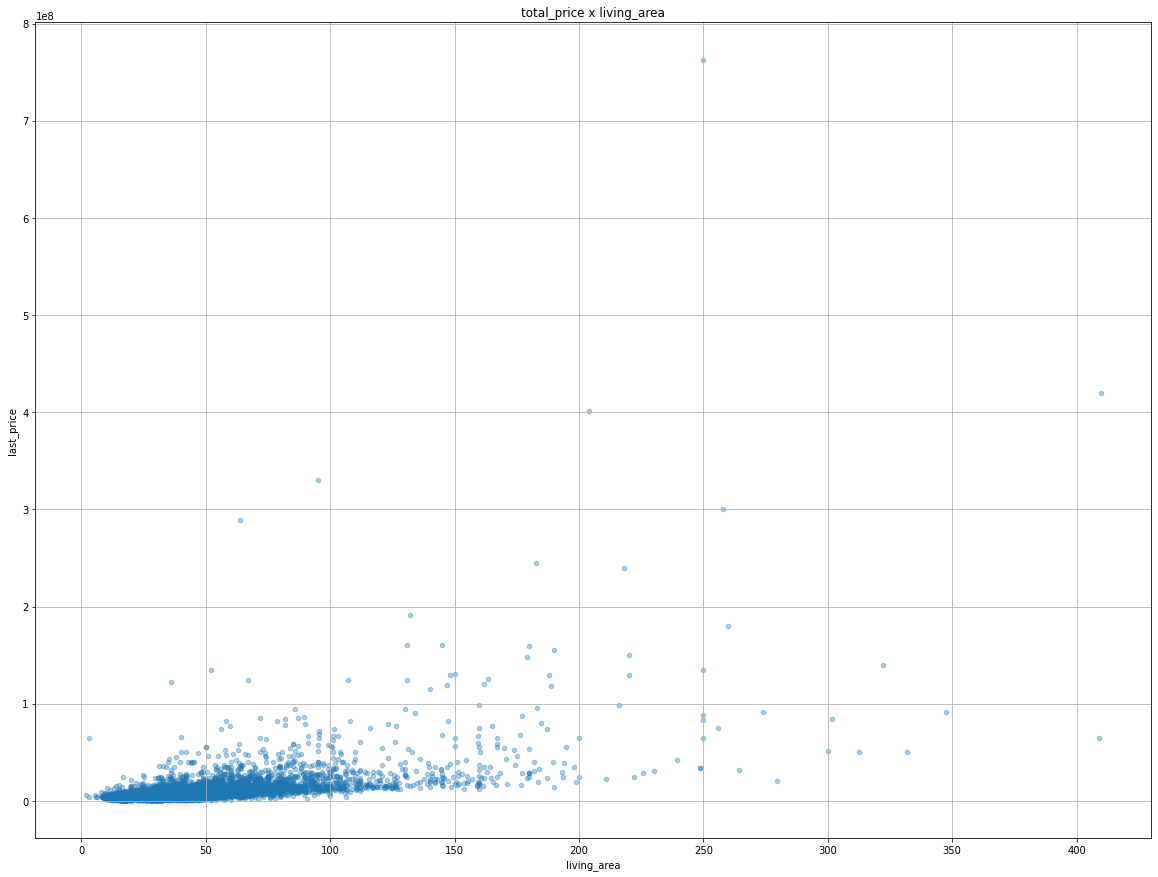

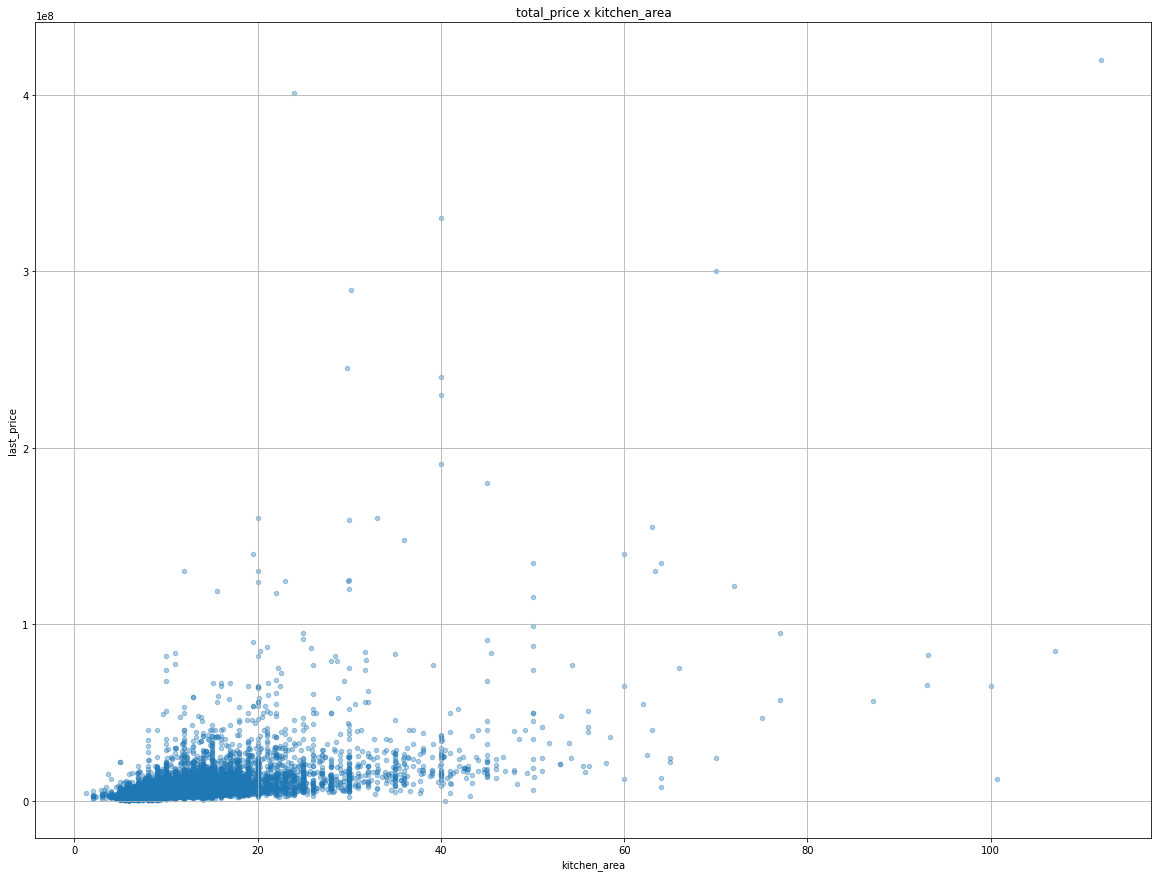

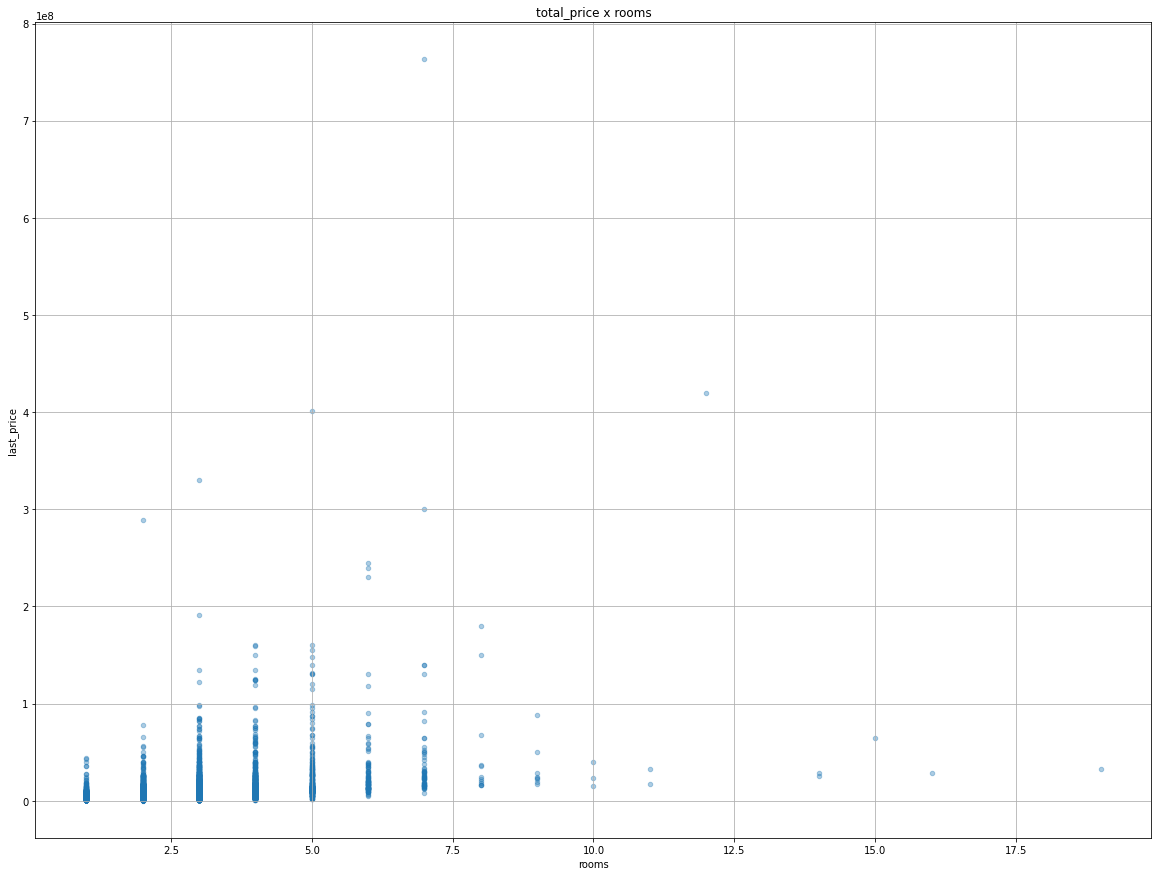

In [28]:
for param in corr_params:
    df.plot(
        title=f'total_price x {param}',
        x=param,
        y='last_price',
        kind='scatter',
        figsize=(20,15),
        alpha=0.37,
        grid=True)
    plt.show()

Посмотрим, не сильно ли влияют на коэффициенты объекты дороже 10 миллионов:

In [29]:
for param in corr_params:
    print(f'Корреляция между last_price (цена до 10 миллионов) и {param} равна {df.query("last_price <= 10000000")["last_price"].corr(df[param])}).')

Корреляция между last_price (цена до 10 миллионов) и total_area равна 0.6568577687041943).
Корреляция между last_price (цена до 10 миллионов) и living_area равна 0.5417998202742315).
Корреляция между last_price (цена до 10 миллионов) и kitchen_area равна 0.4433580010110095).
Корреляция между last_price (цена до 10 миллионов) и rooms равна 0.4240754077624624).


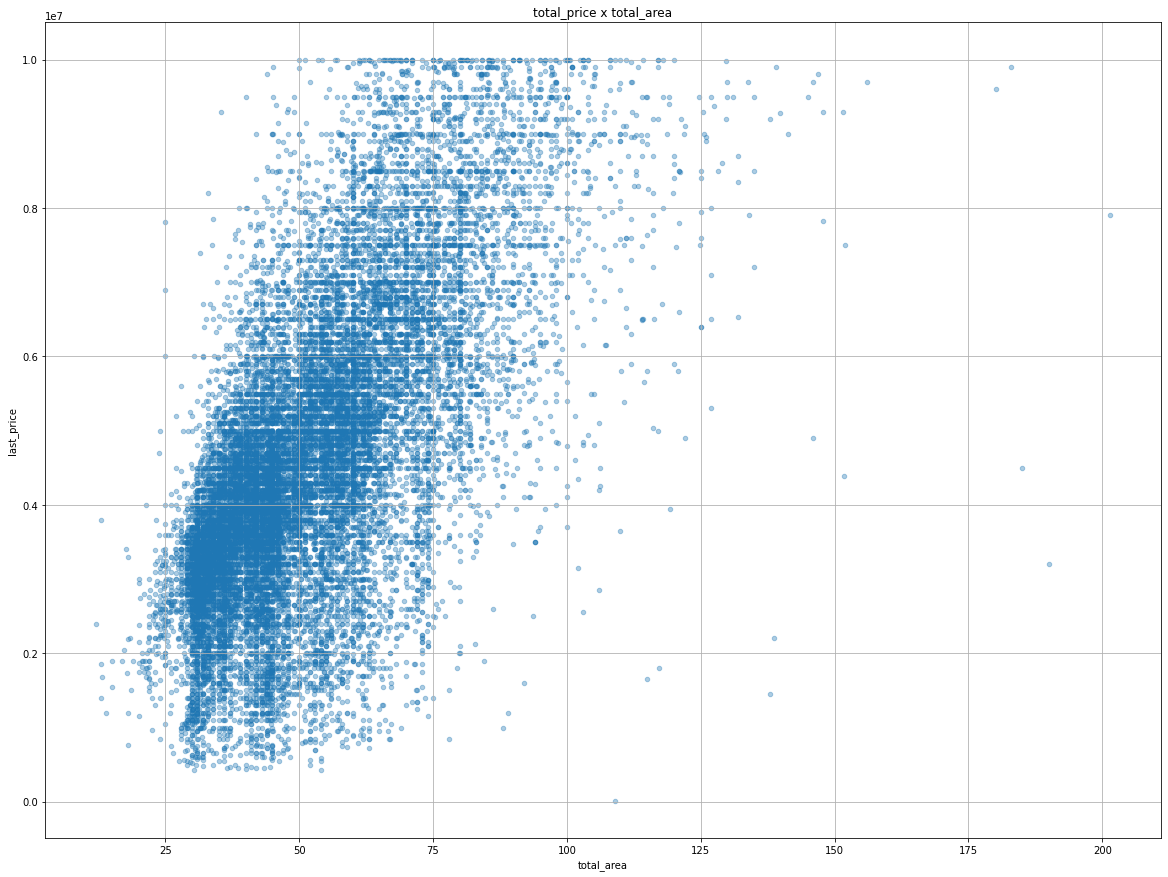

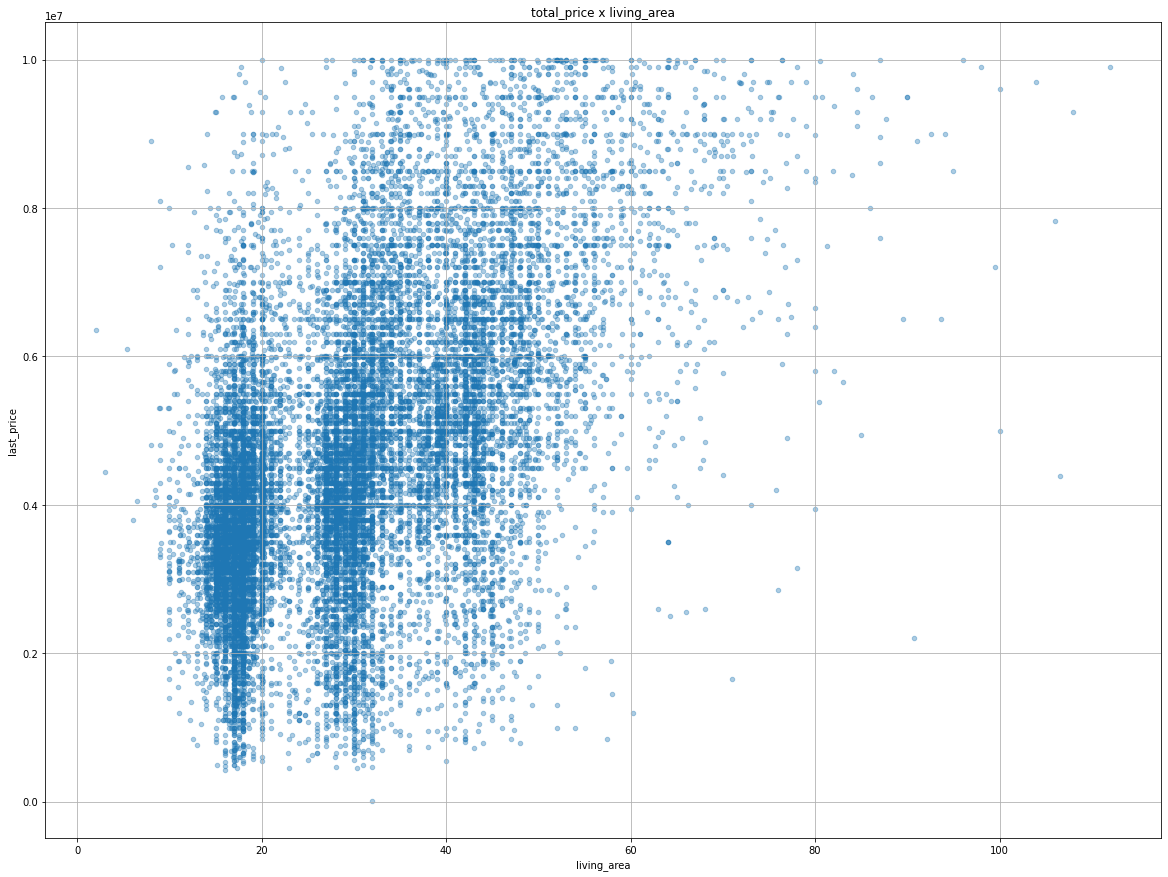

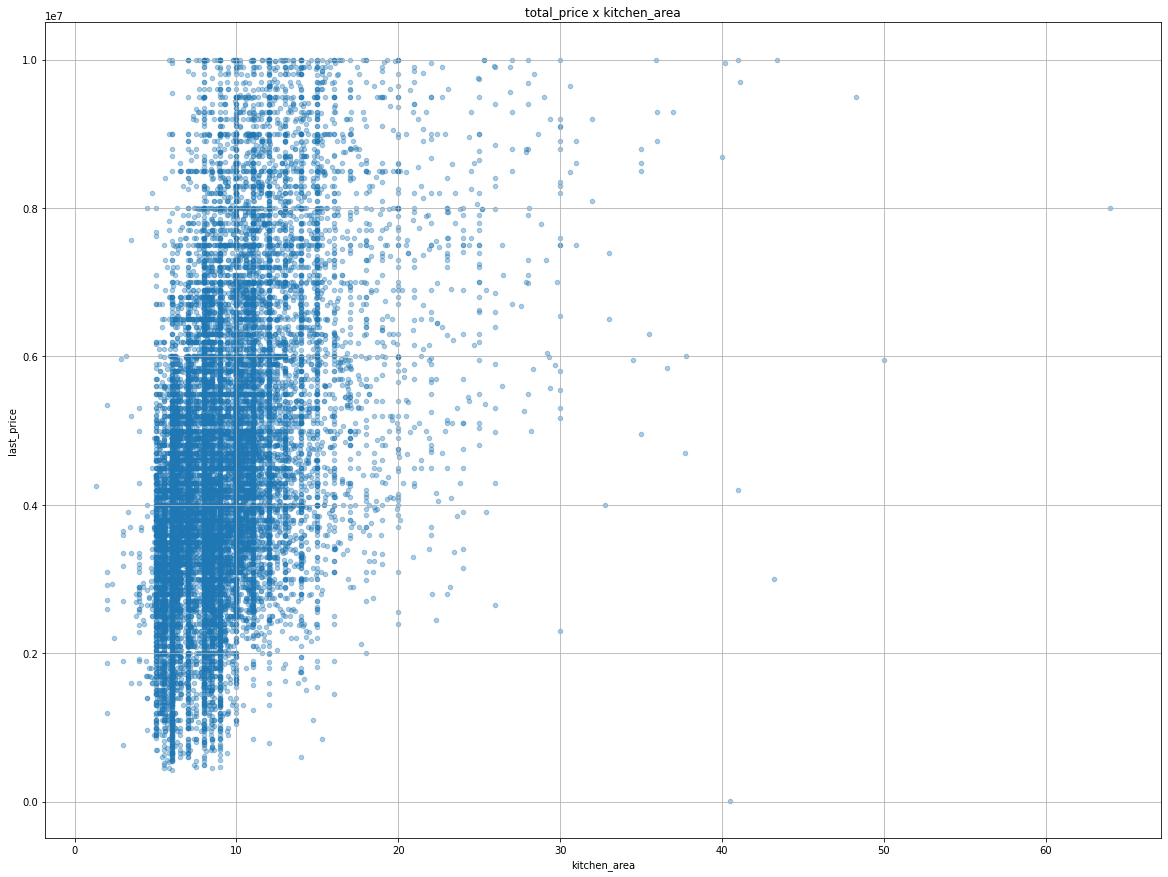

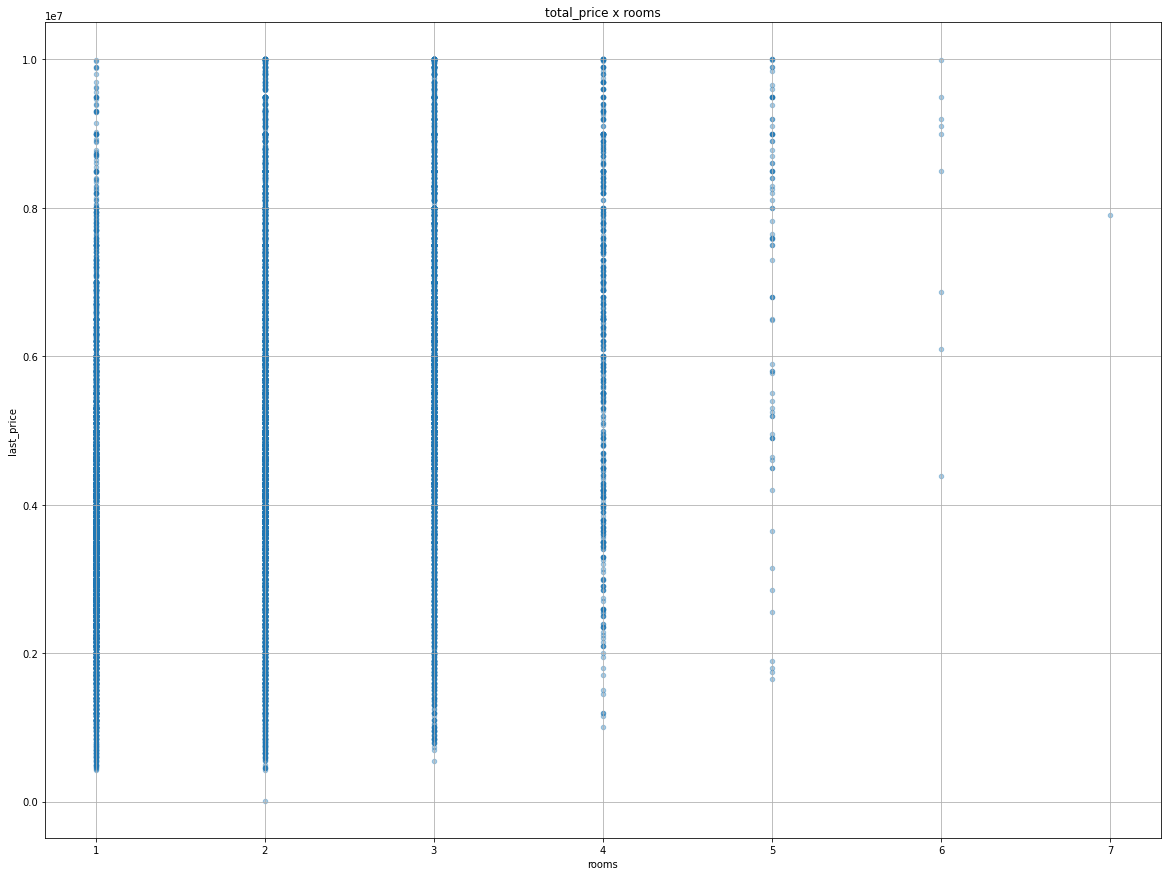

In [30]:
for param in corr_params:
    df.query("last_price <= 10000000").plot(
        title=f'total_price x {param}',
        x=param,
        y='last_price',
        kind='scatter',
        figsize=(20,15),
        alpha=0.37,
        grid=True)
    plt.show()

Коэффициенты для объектов не дороже 10 миллионов почти такие же, как и для полной выборки данных. Значит, влияние выбросов по стоимости жилья не критично.

**Вывод:** итак, как мы видим, конечная цена зависит от всех 4 параметров. Но коэффициент корреляции не оказался ожидаемо очень высоким:
- для общей площади (`total_area`) он составил 0.65 (чуть ниже среднего);
- для жилой площади (`living_area`) он составил 0.57 (ниже среднего);
- для площади кухни (`kitchen_area`) он составил 0.52 (ниже среднего);
- для количества комнат (`rooms`) он составил 0.36 (низкий).

Что говорит о том, что на конечную стоимость объекта гораздо сильнее могут влиять другие параметры.

#### Зависимость цены от типа этажа и даты размещения

Изучим, зависит ли цена (`last_price`) от:
- этажа, на котором расположена квартира (первый, последний, другой) (`floor_cat`);
- даты размещения (день недели, месяц, год) (`exposition_day`, `exposition_month`, `exposition_year`).

Поскольку это категориальные переменные, посчитаем медианные значения цены через сводные таблицы.


In [31]:
df.pivot_table(index='floor_cat',values='last_price',aggfunc=['count', 'median'])

,count,median
,last_price,last_price
floor_cat,,
first,2899,3900000.0
last,3325,4300000.0
other,17278,4872500.0


Для дат размещения, кроме сводных таблиц, дополнительно построим графики для наглядности.

In [32]:
def time_period_pivot_last_price(time_period):
    tmp=df.pivot_table(index=time_period, values='last_price', aggfunc=['count', 'median'])
    display(tmp)
    tmp.plot(
        title=time_period,
        y=('median', 'last_price'),
        style='o-',
        use_index=True,
        figsize=(15, 10))
    plt.show()    

,count,median
,last_price,last_price
exposition_day,,
0,3591,4650000.0
1,4148,4750000.0
2,3944,4700000.0
3,4257,4658000.0
4,3950,4600000.0
5,1924,4600000.0
6,1688,4550000.0


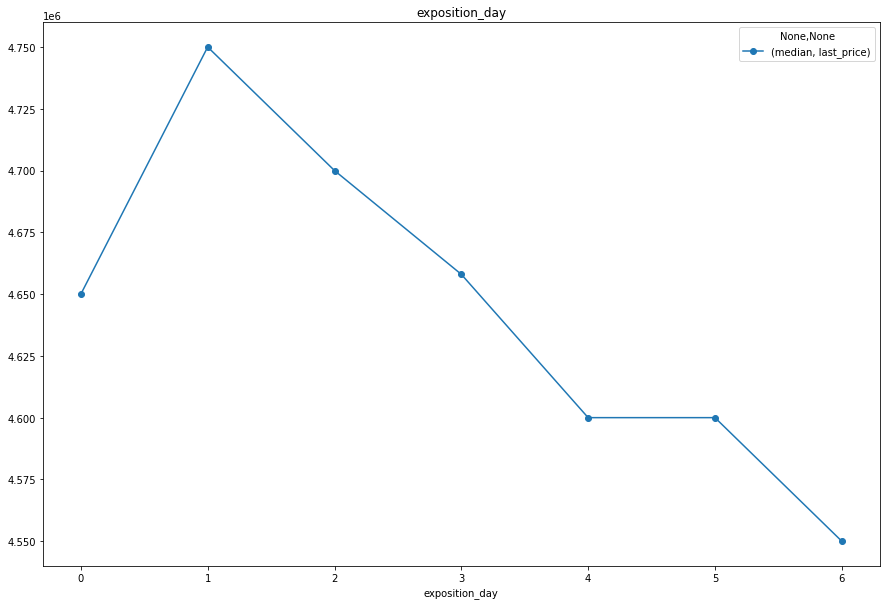

,count,median
,last_price,last_price
exposition_month,,
1,1488,4600000.0
2,2622,4650000.0
3,2570,4697500.0
4,2365,4800000.0
5,1266,4550000.0
6,1756,4400000.0
7,1678,4677500.0
8,1723,4600000.0


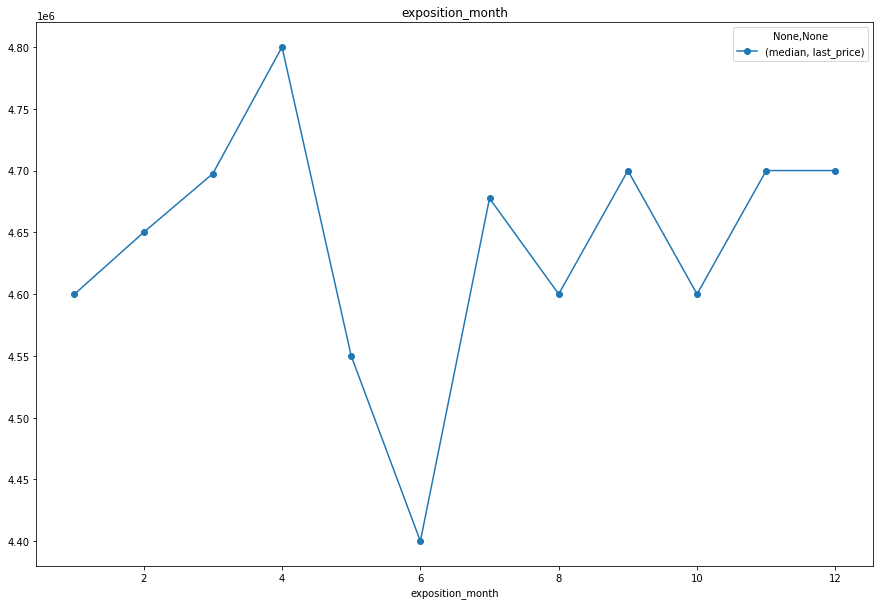

,count,median
,last_price,last_price
exposition_year,,
2014,137,7700000.0
2015,1188,5350000.0
2016,2779,4550000.0
2017,8091,4500000.0
2018,8445,4600000.0
2019,2862,5100000.0


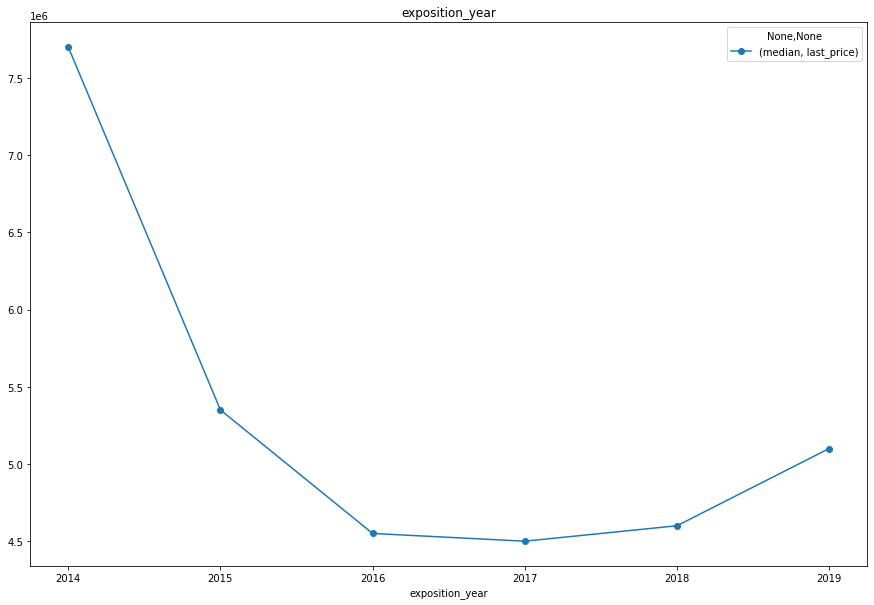

In [33]:
time_periods = ['exposition_day', 'exposition_month', 'exposition_year']

for period in time_periods:
    time_period_pivot_last_price(period)

**Вывод :** квартиры на первом и последних этажах на **20%** и **12%** меньше стоят, чем квартиры, расположенные на иных этажах.

Зависимость между днём или месяцем размещения и ценой незначительна, но её можно выразить следующим образом:
- цена на квартиры, которые размещаются в начале недели (понедельник/вторник), в среднем на **5%** выше цен на квартиры, размещающихся в конце недели (пятница-воскресенье);
- цены на квартиры в апреле - самые высокие, они на **9%** выше самых низких цен в мае-июне.  

А вот зависимость между годом размещения и ценой явно указывает на следующие тренды:
- после 2014 года цена резко упала (на **43%**);
- в период с 2015 года до 2017 года цена медленно снижалась;
- с 2018 года по 2019 год явный тренд на рост цены. 

### Средняя цена квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 

Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [34]:
(
    df
    .pivot_table(index='locality_name', values='price_meter', aggfunc=['count', 'mean'])
    .sort_values(by=('count', 'price_meter'),ascending=False)
    .head(10)
)

,count,mean
,price_meter,price_meter
locality_name,,
Санкт-Петербург,15611,114788.752730
посёлок Мурино,529,85004.057852
посёлок Шушары,436,78405.738420
Всеволожск,392,68618.013712
Пушкин,369,103125.819291
Колпино,338,75424.579098
посёлок Парголово,323,90289.778393
Гатчина,307,68746.146763


**Вывод:** самым дорогим населённым пунктом оказался, ожидаемо, Санкт-Петербург с ценой в 114789 рублей за квадратный метр. А вот самым бюджетным стал Выборг - 58142 рубля за квадратный метр.

### Средняя цена каждого километра до центра города

Ранее мы посчитали расстояние до центра в километрах (`citycenters_km`). Теперь выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра.

In [35]:
df_spb_km_mean = (
    df
    .query("locality_name == 'Санкт-Петербург'")
    .pivot_table(index='citycenters_km', values='last_price', aggfunc=('count', 'mean'))
)

df_spb_km_mean

,count,mean
citycenters_km,,
0.0,27,3.144912e+07
1.0,191,2.127482e+07
2.0,308,1.788662e+07
3.0,349,1.114958e+07
4.0,687,1.332048e+07
5.0,917,1.453061e+07
6.0,611,1.532842e+07
7.0,418,1.483023e+07
8.0,591,1.001749e+07


Для наглядности построим простой график:

<AxesSubplot:xlabel='citycenters_km'>

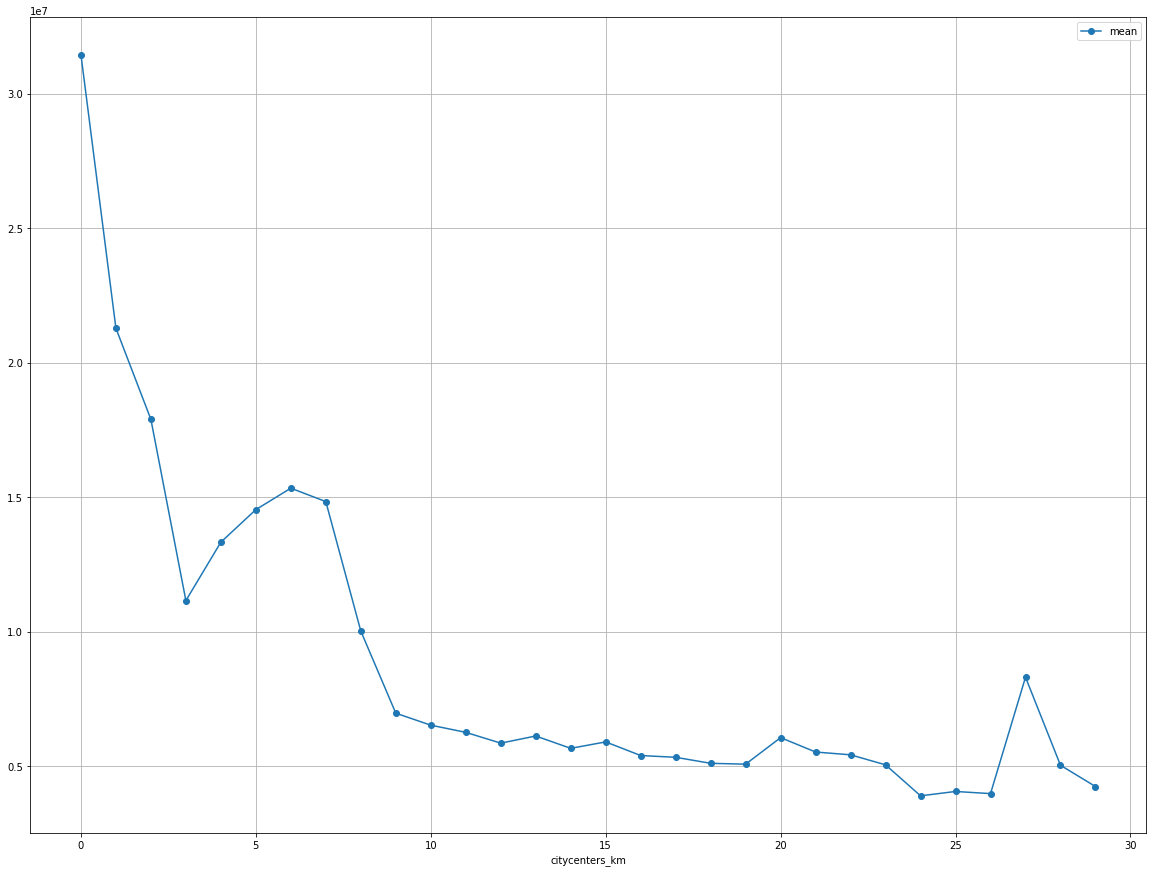

In [36]:
(
    df_spb_km_mean
    .plot(use_index=True, y='mean', style='o-', grid=True, figsize=(20,15))
)

**Вывод:** как мы видим из сводной таблицы и графика, цена закономерно снижается с увеличением расстояния до центра. По своему характеру, зависимость цены от расстояния до центра больше всего похожа на гиперболу. Интересны здесь локальный минимум цены при 3 км до центра и локальный максимум при 27 км до центра.

Локальный минимум может быть объяснён тем, что районы в 3 км до центра - исторически самые старые и качество жилья там соответствующее. Районы в 4,5,6 и 7 км - более новые и предоставляют более комфортную недвижимость.

Локальный максимум в 27 км представляет собой группу из всего 2ух квартир (см. данные ниже), одна из которых является объектом "комфорт"- или "бизнес-класса". Если бы в группу входило большее количество квартир, влияние такого выброса было бы меньше. 

In [37]:
df[(df['citycenters_km'] == 27) & (df['locality_name'] == 'Санкт-Петербург')]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,exposition_day,exposition_month,exposition_year,citycenters_km,floor_cat
748,13,14350000.0,74.0,2017-11-28,2,3.13,5.0,30.0,3,False,False,False,25.0,0,Санкт-Петербург,23888.0,27313.0,1.0,1496.0,0.0,NaN,128.0,193918.918919,1,11,2017,27.0,other
5961,6,2250000.0,32.0,2018-02-27,1,NaN,2.0,16.5,2,False,False,False,7.0,0,Санкт-Петербург,24006.0,27431.0,0.0,NaN,0.0,NaN,178.0,70312.500000,1,2,2018,27.0,last


## Общий вывод

Мы изучили первичную информацию о наборе данных, построили гистограммы на необработанных данных и получили общие сведения из .info().

В ходе этапа предобработки данных мы:
- обработали пропущенные значения в столбцах "количество балконов" и "тип объекта (апартаменты)";
- обнаружили, что при загрузке данных была произведена техническая ошибка, которая привела к тому, что 5518 записей одновременно потеряли значения в 6 столбцах;
- изменили типы данных даты публикации (на datetime) и количества балконов (int);
- обнаружили и исправили неявные дубликаты в столбце "имя населённого пункта";
- обнаружили аномалии в столбцах "высота потолков" и "количество комнат"; часть записей была исправлена, а часть - отброшена;
- привели названия всех столбцов к единому типу.

Далее мы добавили в таблицу новые столбцы:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- расстояние до центра города в километрах;
- тип этажа квартиры (значения — «first», «last», «other»).

В ходе EDA мы выяснили, что:
- объекты недвижимости предпочитают выставлять на продажу в рабочие дни;
- меньше всего выставляют объектов на продажу в следующие месяцы - январь, май и декабрь; неохотно выставляют квартиры в июне, июле и августе; а больше всего предложений продажи появляется в феврале, марте и апреле;
- в среднем, продажа обычно занимает 96 дней (медианное значение) - 50% квартир из набора данных были проданы именно за 96 дней. Быстрыми можно считать продажи длительностью меньше 1.5 месяцев. Долгими продажами являются от 232 до 500 дней; и аномально долгими - больше 500; также мы обнаружили характерные для риэлторских агентств пики продаж в 7, 30, 45, 60 и 90 дней - случаи срочного выкупа жилья у собственников.
- цена  зависит от общей площади, жилой площади, площади кухни и количества комнат. Данные параметры влияют на цену со средней - ниже-среднего силой (коэффициенты корреляции колеблются от 0.65 до 0.36);
- квартиры на первом и последних этажах на 20% и 12% меньше стоят, чем квартиры, расположенные на иных этажах;
- зависимость между днём или месяцем размещения и ценой незначительна, но её можно выразить следующим образом: цена на квартиры, которые размещаются в начале недели (понедельник/вторник), в среднем на **5%** выше цен на квартиры, размещающихся в конце недели (пятница-воскресенье); цены на квартиры в апреле - самые высокие, они на **9%** выше самых низких цен в мае-июне;
- после 2014 года цена на объекты резко упала (на 43%); в период с 2015 года до 2017 года цена медленно снижалась; с 2018 года по 2019 год явный тренд на рост цены;
- самым дорогим населённым пунктом оказался Санкт-Петербург с ценой в 114789 рублей за квадратный метр, а самым бюджетным стал Выборг - 58142 рубля за квадратный метр;
- цены в Санкт-Петербурге снижаются с увеличением расстояния до центра; зависимость цены от расстояния до центра больше всего похожа на гиперболу.